<a href="https://colab.research.google.com/github/JoaoMMS98/ML_2.0/blob/main/Chiel_EDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Imports

In [1]:
# General Imports
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats  # Import stats only once

# Sklearn packages
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.feature_selection import mutual_info_classif  # Import mutual_info_classif only once

# Other imports
from scipy.stats import chi2_contingency
from typing import List, Optional
import warnings

In [2]:
# We want to predict Claim Injury Type

In [3]:
test_df = pd.read_csv("test_data.csv") #./data/

In [4]:
train_df = pd.read_csv("train_data.csv", dtype={ 29 : str}) #./data/

In [5]:
train_df.head()

,Accident Date,Age at Injury,Alternative Dispute Resolution,Assembly Date,Attorney/Representative,Average Weekly Wage,Birth Year,C-2 Date,C-3 Date,Carrier Name,...,WCIO Cause of Injury Code,WCIO Cause of Injury Description,WCIO Nature of Injury Code,WCIO Nature of Injury Description,WCIO Part Of Body Code,WCIO Part Of Body Description,Zip Code,Agreement Reached,WCB Decision,Number of Dependents
0,2019-12-30,31.0,N,2020-01-01,N,0.00,1988.0,2019-12-31,NaN,NEW HAMPSHIRE INSURANCE CO,...,27.0,FROM LIQUID OR GREASE SPILLS,10.0,CONTUSION,62.0,BUTTOCKS,13662,0.0,Not Work Related,1.0
1,2019-08-30,46.0,N,2020-01-01,Y,1745.93,1973.0,2020-01-01,2020-01-14,ZURICH AMERICAN INSURANCE CO,...,97.0,REPETITIVE MOTION,49.0,SPRAIN OR TEAR,38.0,SHOULDER(S),14569,1.0,Not Work Related,4.0
2,2019-12-06,40.0,N,2020-01-01,N,1434.80,1979.0,2020-01-01,NaN,INDEMNITY INSURANCE CO OF,...,79.0,OBJECT BEING LIFTED OR HANDLED,7.0,CONCUSSION,10.0,MULTIPLE HEAD INJURY,12589,0.0,Not Work Related,6.0
3,NaN,NaN,NaN,2020-01-01,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2019-12-30,61.0,N,2020-01-01,N,NaN,1958.0,2019-12-31,NaN,STATE INSURANCE FUND,...,16.0,"HAND TOOL, UTENSIL; NOT POWERED",43.0,PUNCTURE,36.0,FINGER(S),12603,0.0,Not Work Related,1.0


In [6]:
for col in train_df.columns:
    if col not in test_df.columns:
        print(col +" not in test")

Claim Injury Type not in test
Agreement Reached not in test
WCB Decision not in test


In [7]:
#train_df = train_df.drop(["Agreement Reached", "WCB Decision"],axis=1)

In [8]:
train_df["Claim Injury Type"].unique()

array(['2. NON-COMP', '4. TEMPORARY', nan, '3. MED ONLY',
       '5. PPD SCH LOSS', '6. PPD NSL', '1. CANCELLED', '8. DEATH',
       '7. PTD'], dtype=object)

In [9]:
train_df["Claim Injury Type"].value_counts()

,count
Claim Injury Type,
2. NON-COMP,291078
4. TEMPORARY,148507
3. MED ONLY,68906
5. PPD SCH LOSS,48280
1. CANCELLED,12477
6. PPD NSL,4211
8. DEATH,470
7. PTD,97


The dataset is very unbalanced: </br>
    - PPD NSL, DEATH and PTD combined got less than 5k

In [10]:
train_df.info()

# ""First Hearing Date" has only 83,932 non-null entries, leaving most of the rows missing.
# "IME-4 Count" has only 71,843 non-null values, indicating a significant portion of missing data.
# "C-3 Date" has fewer entries (102,971), compared to "C-2 Date" (285,444), suggesting sparse data in the "C-3 Date" field.
# "OIICS Nature of Injury Description" is completely empty, with 0 non-null values

# 11 columns contain strings (text) or other types that are represented as objects, including date columns (e.g., "Accident Date," "Assembly Date") and categorical fields (e.g., "Carrier Name," "Gender").


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 593471 entries, 0 to 593470
Data columns (total 33 columns):
 #   Column                              Non-Null Count   Dtype  
---  ------                              --------------   -----  
 0   Accident Date                       570337 non-null  object 
 1   Age at Injury                       574026 non-null  float64
 2   Alternative Dispute Resolution      574026 non-null  object 
 3   Assembly Date                       593471 non-null  object 
 4   Attorney/Representative             574026 non-null  object 
 5   Average Weekly Wage                 545375 non-null  float64
 6   Birth Year                          544948 non-null  float64
 7   C-2 Date                            559466 non-null  object 
 8   C-3 Date                            187245 non-null  object 
 9   Carrier Name                        574026 non-null  object 
 10  Carrier Type                        574026 non-null  object 
 11  Claim Identifier          

In [11]:
train_df.describe().T

# outliers or data entry errors, especially for "Average Weekly Wage" and "Birth Year."
# variables contain zeros, age at injury, average weekly wage, birth_year, WCIO Part of the Body Code, Agreement Reached, Number of Dependents

# Age at Injury: Mean 42, range 0–117, most 31–54.
# Average Weekly Wage: Mean 504.6, max 2.6M, median 0.
# Birth Year: Mean 1877 (errors), most 1964–1988.
# Claim Identifier: Range 5.4M–1B.
# IME-4 Count: Mean 3.46, max 48.
# Industry Code: Range 11–92, most 45–62.
# WCIO Codes: Mid-range, Part of Body min -9 (error).
# Agreement Reached: Mean 0.06.
# Number of Dependents: Mean 3, max 6.


,count,mean,std,min,25%,50%,75%,max
Age at Injury,574026.0,4.211427e+01,1.425643e+01,0.0,31.0,42.0,54.0,117.0
Average Weekly Wage,545375.0,4.910883e+02,6.092918e+03,0.0,0.0,0.0,841.0,2828079.0
Birth Year,544948.0,1.886768e+03,4.146444e+02,0.0,1965.0,1977.0,1989.0,2018.0
Claim Identifier,593471.0,2.366760e+07,1.079271e+08,5393066.0,5593414.5,5791212.0,5991000.5,999891667.0
IME-4 Count,132803.0,3.207337e+00,2.832303e+00,1.0,1.0,2.0,4.0,73.0
Industry Code,564068.0,5.864531e+01,1.964417e+01,11.0,45.0,61.0,71.0,92.0
OIICS Nature of Injury Description,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
WCIO Cause of Injury Code,558386.0,5.438114e+01,2.587428e+01,1.0,31.0,56.0,75.0,99.0
WCIO Nature of Injury Code,558369.0,4.101384e+01,2.220752e+01,1.0,16.0,49.0,52.0,91.0
WCIO Part Of Body Code,556944.0,3.973815e+01,2.236594e+01,-9.0,33.0,38.0,53.0,99.0


In [12]:
train_df["WCB Decision"].unique()
# Very weird, we cannot assume that nan are Work Related cases as the decision is unknown at the start of claim

array(['Not Work Related', nan], dtype=object)

In [13]:
categorical_columns = [
    'Alternative Dispute Resolution',  # Y/N values
    'Attorney Representative',         # Y/N values
    'Carrier Name',                   # Company names
    'Carrier Type',                   # Types like "1A. PRIVATE"
    'Claim Injury_Type',              # Types like "2. NON-COMP"
    'County of Injury',               # County names
    'COVID_19 Indicator',             # Y/N values
    'District Name',                  # District names
    'Gender',                         # M/F values
    'Industry Code Description',      # Industry descriptions
    'Medical Fee Region',             # Regions I, II, III, IV
    'OIICS_Nature of Injury Description',  # Injury descriptions
    'WCIO Cause of Injury Description',    # Cause descriptions
    'WCIO Nature of Injury Description',   # Nature descriptions
    'WCIO Part Of Body Description',       # Body part descriptions
    'Agreement Reached',              # 0/1 values
    'WCB Decision'                    # Decision descriptions
]

numeric_cols = [
    'Age at Injury',                # Continuous
    'Average Weekly Wage',          # Continuous
    'Birth Year',                   # Discrete
    'Claim Identifier',             # Discrete
    'Industry Code',                # Discrete
    'IME-4 Count',                  # Discrete
    'WCIO Cause of Injury Code',    # Discrete
    'WCIO Nature of Injury Code',   # Discrete
    'WCIO Part Of Body Code',       # Discrete
    'Number of Dependents',         # Discrete
    'Zip Code'                      # Discrete (could be categorical)
    ]

date_variables = [

]

In [14]:
def analyze_categorical_features_enhanced(data):
    """
    Enhanced analysis of categorical features with additional metrics and better formatting
    """
    # Define categorical columns based on the actual data
    categorical_columns = [
    'Alternative Dispute Resolution',  # Y/N values
    'Attorney Representative',         # Y/N values
    'Carrier Name',                   # Company names
    'Carrier Type',                   # Types like "1A. PRIVATE"
    'Claim Injury_Type',              # Types like "2. NON-COMP"
    'County of Injury',               # County names
    'COVID_19 Indicator',             # Y/N values
    'District Name',                  # District names
    'Gender',                         # M/F values
    'Industry Code Description',      # Industry descriptions
    'Medical Fee Region',             # Regions I, II, III, IV
    'OIICS_Nature of Injury Description',  # Injury descriptions
    'WCIO Cause of Injury Description',    # Cause descriptions
    'WCIO Nature of Injury Description',   # Nature descriptions
    'WCIO Part Of Body Description',       # Body part descriptions
    'Agreement Reached',              # 0/1 values
    'WCB Decision'                    # Decision descriptions
]

    analysis_results = {}

    for column in categorical_columns:
        if column in data.columns:  # Check if column exists in dataframe
            print(f"\n{'='*70}")
            print(f"DETAILED ANALYSIS FOR: {column}")
            print('='*70)

            # Value counts with percentages
            value_counts = data[column].value_counts()
            value_percentages = data[column].value_counts(normalize=True) * 100

            print("\nTop 3 Values Distribution:")
            print("-"*50)
            for val, count in value_counts.head(3).items():
                percentage = value_percentages[val]
                print(f"{val}: {count:,} occurrences ({percentage:.2f}%)")

            # Unique values analysis
            unique_count = data[column].nunique()
            total_count = len(data)
            uniqueness_ratio = (unique_count / total_count) * 100
            print(f"\nUniqueness Analysis:")
            print("-"*50)
            print(f"Unique values: {unique_count:,}")
            print(f"Uniqueness ratio: {uniqueness_ratio:.2f}% of total records")

            # Numeric statistics if applicable
            if pd.api.types.is_numeric_dtype(data[column]):
                print("\nNumerical Statistics:")
                print("-"*50)
                stats = data[column].describe()
                print(stats)

            # Missing values analysis
            missing_count = data[column].isnull().sum()
            missing_percentage = (missing_count / len(data)) * 100
            print(f"\nMissing Values Analysis:")
            print("-"*50)
            print(f"Missing count: {missing_count:,}")
            print(f"Missing percentage: {missing_percentage:.2f}%")

            # Additional cardinality metrics for non-numeric data
            if not pd.api.types.is_numeric_dtype(data[column]):
                print("\nCardinality Analysis:")
                print("-"*50)
                rare_values = value_counts[value_counts == 1].count()
                print(f"Number of values appearing only once: {rare_values:,}")
                print(f"Percentage of rare values: {(rare_values/unique_count)*100:.2f}%")

            # Store results
            analysis_results[column] = {
                'unique_count': unique_count,
                'missing_count': missing_count,
                'missing_percentage': missing_percentage,
                'value_counts': value_counts,
                'uniqueness_ratio': uniqueness_ratio
            }
        else:
            print(f"\nWarning: Column '{column}' not found in the dataset")

    return analysis_results

# To use the function:
enhanced_analysis = analyze_categorical_features_enhanced(train_df)


DETAILED ANALYSIS FOR: Alternative Dispute Resolution

Top 3 Values Distribution:
--------------------------------------------------
N: 571,412 occurrences (99.54%)
Y: 2,609 occurrences (0.45%)
U: 5 occurrences (0.00%)

Uniqueness Analysis:
--------------------------------------------------
Unique values: 3
Uniqueness ratio: 0.00% of total records

Missing Values Analysis:
--------------------------------------------------
Missing count: 19,445
Missing percentage: 3.28%

Cardinality Analysis:
--------------------------------------------------
Number of values appearing only once: 0
Percentage of rare values: 0.00%


DETAILED ANALYSIS FOR: Carrier Name

Top 3 Values Distribution:
--------------------------------------------------
STATE INSURANCE FUND: 111,144 occurrences (19.36%)
POLICE, FIRE, SANITATION: 21,602 occurrences (3.76%)
AMERICAN ZURICH INSURANCE CO: 17,540 occurrences (3.06%)

Uniqueness Analysis:
--------------------------------------------------
Unique values: 2,046
Uniqu

### Missing value, Dups and Feature encoding

#### See if there are missing values on the target

In [15]:
nan_count = train_df["Claim Injury Type"].isna().sum()
print(f"We found that {nan_count/train_df.shape[0] * 100}% of the training data has NAs on the target, therefor we will drop it.")
#nan_rows.value_counts
train_df = train_df.dropna(subset=["Claim Injury Type"])

We found that 3.276486972404717% of the training data has NAs on the target, therefor we will drop it.


#### See if there are duplicates on the dataset

In [16]:
dup_rows = train_df.duplicated()
dup_rows.value_counts()

,count
False,574026


In [17]:
train_df.columns

Index(['Accident Date', 'Age at Injury', 'Alternative Dispute Resolution',
       'Assembly Date', 'Attorney/Representative', 'Average Weekly Wage',
       'Birth Year', 'C-2 Date', 'C-3 Date', 'Carrier Name', 'Carrier Type',
       'Claim Identifier', 'Claim Injury Type', 'County of Injury',
       'COVID-19 Indicator', 'District Name', 'First Hearing Date', 'Gender',
       'IME-4 Count', 'Industry Code', 'Industry Code Description',
       'Medical Fee Region', 'OIICS Nature of Injury Description',
       'WCIO Cause of Injury Code', 'WCIO Cause of Injury Description',
       'WCIO Nature of Injury Code', 'WCIO Nature of Injury Description',
       'WCIO Part Of Body Code', 'WCIO Part Of Body Description', 'Zip Code',
       'Agreement Reached', 'WCB Decision', 'Number of Dependents'],
      dtype='object')

Change Zip Code to be only str as by deafual its both

In [18]:
train_df['Zip Length'] = train_df['Zip Code'].str.len()

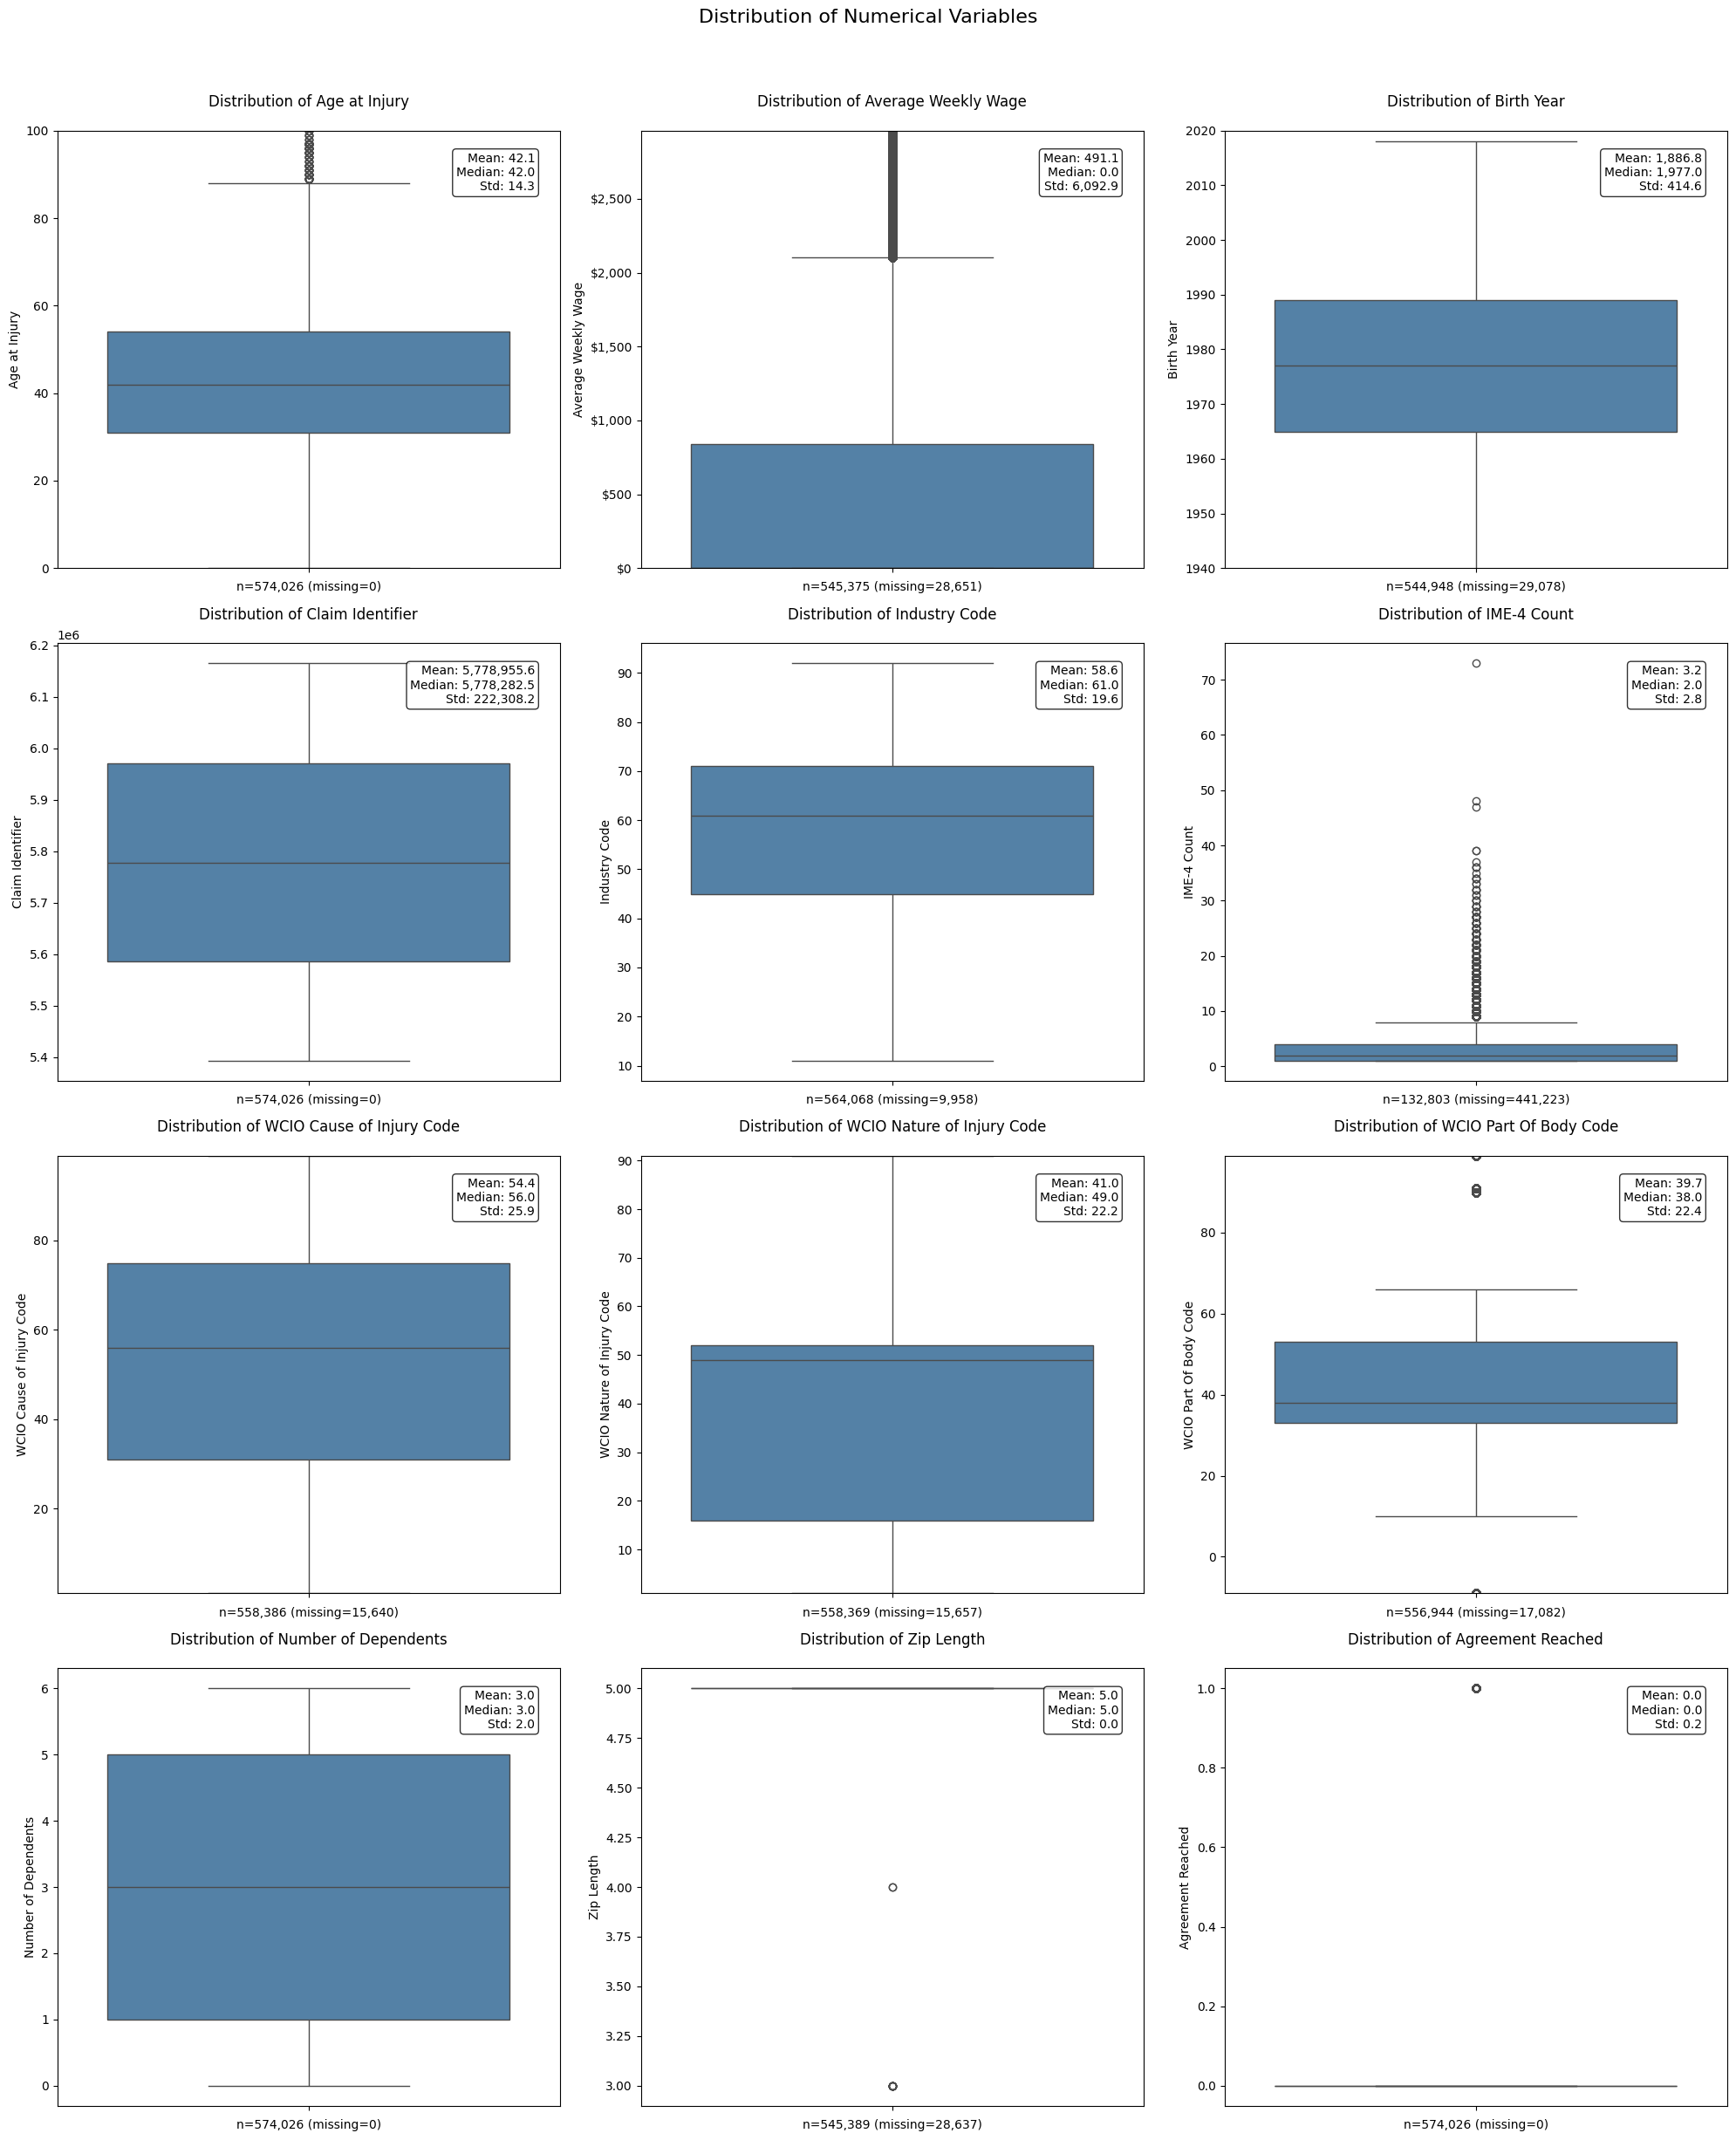


=== Age at Injury ===
count    574026.000000
mean         42.114270
std          14.256432
min           0.000000
25%          31.000000
50%          42.000000
75%          54.000000
max         117.000000
Name: Age at Injury, dtype: float64
Missing values: 0 (0.0%)
--------------------------------------------------

=== Average Weekly Wage ===
count    5.453750e+05
mean     4.910883e+02
std      6.092918e+03
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      8.410000e+02
max      2.828079e+06
Name: Average Weekly Wage, dtype: float64
Missing values: 28,651 (5.0%)
Sum: $267,827,292.89
99th percentile: $2,961.97
--------------------------------------------------

=== Birth Year ===
count    544948.000000
mean       1886.767604
std         414.644423
min           0.000000
25%        1965.000000
50%        1977.000000
75%        1989.000000
max        2018.000000
Name: Birth Year, dtype: float64
Missing values: 29,078 (5.1%)
--------------------------------------

In [19]:


def create_comprehensive_boxplots(df):
    """
    Create boxplots for all relevant numerical columns with appropriate scaling
    """
    # Create a working copy of the dataframe
    df_work = df.copy()

    # Convert Zip Code to numeric, handling any non-numeric values
    df_work['Zip Code'] = pd.to_numeric(df_work['Zip Code'], errors='coerce')

    # Define numerical columns to plot based on actual numeric dtypes
    numeric_cols = [
        'Age at Injury',
        'Average Weekly Wage',
        'Birth Year',
        'Claim Identifier',
        'Industry Code',
        'IME-4 Count',
        'WCIO Cause of Injury Code',
        'WCIO Nature of Injury Code',
        'WCIO Part Of Body Code',
        'Number of Dependents',
        'Zip Length',
        'Agreement Reached'
    ]

    # Verify columns exist and are numeric
    numeric_cols = [col for col in numeric_cols if col in df_work.columns and
                   (pd.api.types.is_numeric_dtype(df_work[col]) or col == 'Zip Code')]

    # Calculate number of rows and columns for subplot grid
    n_cols = 3
    n_rows = (len(numeric_cols) + n_cols - 1) // n_cols

    # Create subplots
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 6*n_rows))
    fig.suptitle('Distribution of Numerical Variables', fontsize=16, y=1.02)

    # Ensure axes is always a 2D array
    if n_rows == 1:
        axes = np.array([axes])
    if n_cols == 1:
        axes = axes.reshape(-1, 1)

    # Flatten axes array for easier iteration
    axes_flat = axes.flatten()

    for i, col in enumerate(numeric_cols):
        ax = axes_flat[i]

        try:
            # Create boxplot
            sns.boxplot(data=df_work, y=col, ax=ax, color='steelblue')

            # Calculate statistics
            valid_data = df_work[col].dropna()
            mean_val = valid_data.mean()
            median_val = valid_data.median()
            std_val = valid_data.std()

            stats_text = (f'Mean: {mean_val:,.1f}\n'
                         f'Median: {median_val:,.1f}\n'
                         f'Std: {std_val:,.1f}')

            # Add statistics box
            ax.text(0.95, 0.95, stats_text,
                   transform=ax.transAxes,
                   verticalalignment='top',
                   horizontalalignment='right',
                   bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

            # Customize plot based on variable
            ax.set_title(f'Distribution of {col}', pad=20)

            # Add sample size and missing value count
            n_valid = valid_data.count()
            n_missing = df_work[col].isna().sum()
            ax.set_xlabel(f'n={n_valid:,} (missing={n_missing:,})')

            # Variable-specific customization
            if col == 'Average Weekly Wage':
                ax.set_ylim(0, valid_data.quantile(0.99))
                ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x:,.0f}'))
            elif col == 'Birth Year':
                ax.set_ylim(1940, 2020)
            elif col == 'Age at Injury':
                ax.set_ylim(0, 100)
            elif col in ['WCIO Cause of Injury Code', 'WCIO Nature of Injury Code', 'WCIO Part Of Body Code']:
                ax.set_ylim(valid_data.min(), valid_data.max())

        except Exception as e:
            print(f"Error plotting {col}: {str(e)}")
            ax.text(0.5, 0.5, f'Error plotting {col}',
                   ha='center', va='center')
            ax.set_xticks([])
            ax.set_yticks([])

    # Remove empty subplots if any
    for j in range(i + 1, len(axes_flat)):
        fig.delaxes(axes_flat[j])

    plt.tight_layout()
    return fig

def print_numerical_summaries(df):
    """
    Print detailed summaries for all numerical columns
    """
    # Create a working copy of the dataframe
    df_work = df.copy()

    # Convert Zip Code to numeric
    df_work['Zip Code'] = pd.to_numeric(df_work['Zip Code'], errors='coerce')

    numeric_cols = [
        'Age at Injury',
        'Average Weekly Wage',
        'Birth Year',
        'Industry Code',
        'IME-4 Count',
        'WCIO Cause of Injury Code',
        'WCIO Nature of Injury Code',
        'WCIO Part Of Body Code',
        'Number of Dependents',
        'Zip Length',
        'Agreement Reached'
    ]

    for col in numeric_cols:
        if col not in df_work.columns:
            print(f"\nColumn '{col}' not found in DataFrame")
            continue

        print(f"\n=== {col} ===")
        try:
            stats = df_work[col].describe()
            print(stats)
            print(f"Missing values: {df_work[col].isna().sum():,} ({df_work[col].isna().mean():.1%})")

            # Additional statistics for monetary values
            if col == 'Average Weekly Wage':
                print(f"Sum: ${df_work[col].sum():,.2f}")
                print(f"99th percentile: ${df_work[col].quantile(0.99):,.2f}")

        except Exception as e:
            print(f"Error processing column: {str(e)}")
        print("-" * 50)

fig = create_comprehensive_boxplots(train_df)
plt.show()
print_numerical_summaries(train_df)

In [20]:
print(train_df.columns.tolist())

['Accident Date', 'Age at Injury', 'Alternative Dispute Resolution', 'Assembly Date', 'Attorney/Representative', 'Average Weekly Wage', 'Birth Year', 'C-2 Date', 'C-3 Date', 'Carrier Name', 'Carrier Type', 'Claim Identifier', 'Claim Injury Type', 'County of Injury', 'COVID-19 Indicator', 'District Name', 'First Hearing Date', 'Gender', 'IME-4 Count', 'Industry Code', 'Industry Code Description', 'Medical Fee Region', 'OIICS Nature of Injury Description', 'WCIO Cause of Injury Code', 'WCIO Cause of Injury Description', 'WCIO Nature of Injury Code', 'WCIO Nature of Injury Description', 'WCIO Part Of Body Code', 'WCIO Part Of Body Description', 'Zip Code', 'Agreement Reached', 'WCB Decision', 'Number of Dependents', 'Zip Length']


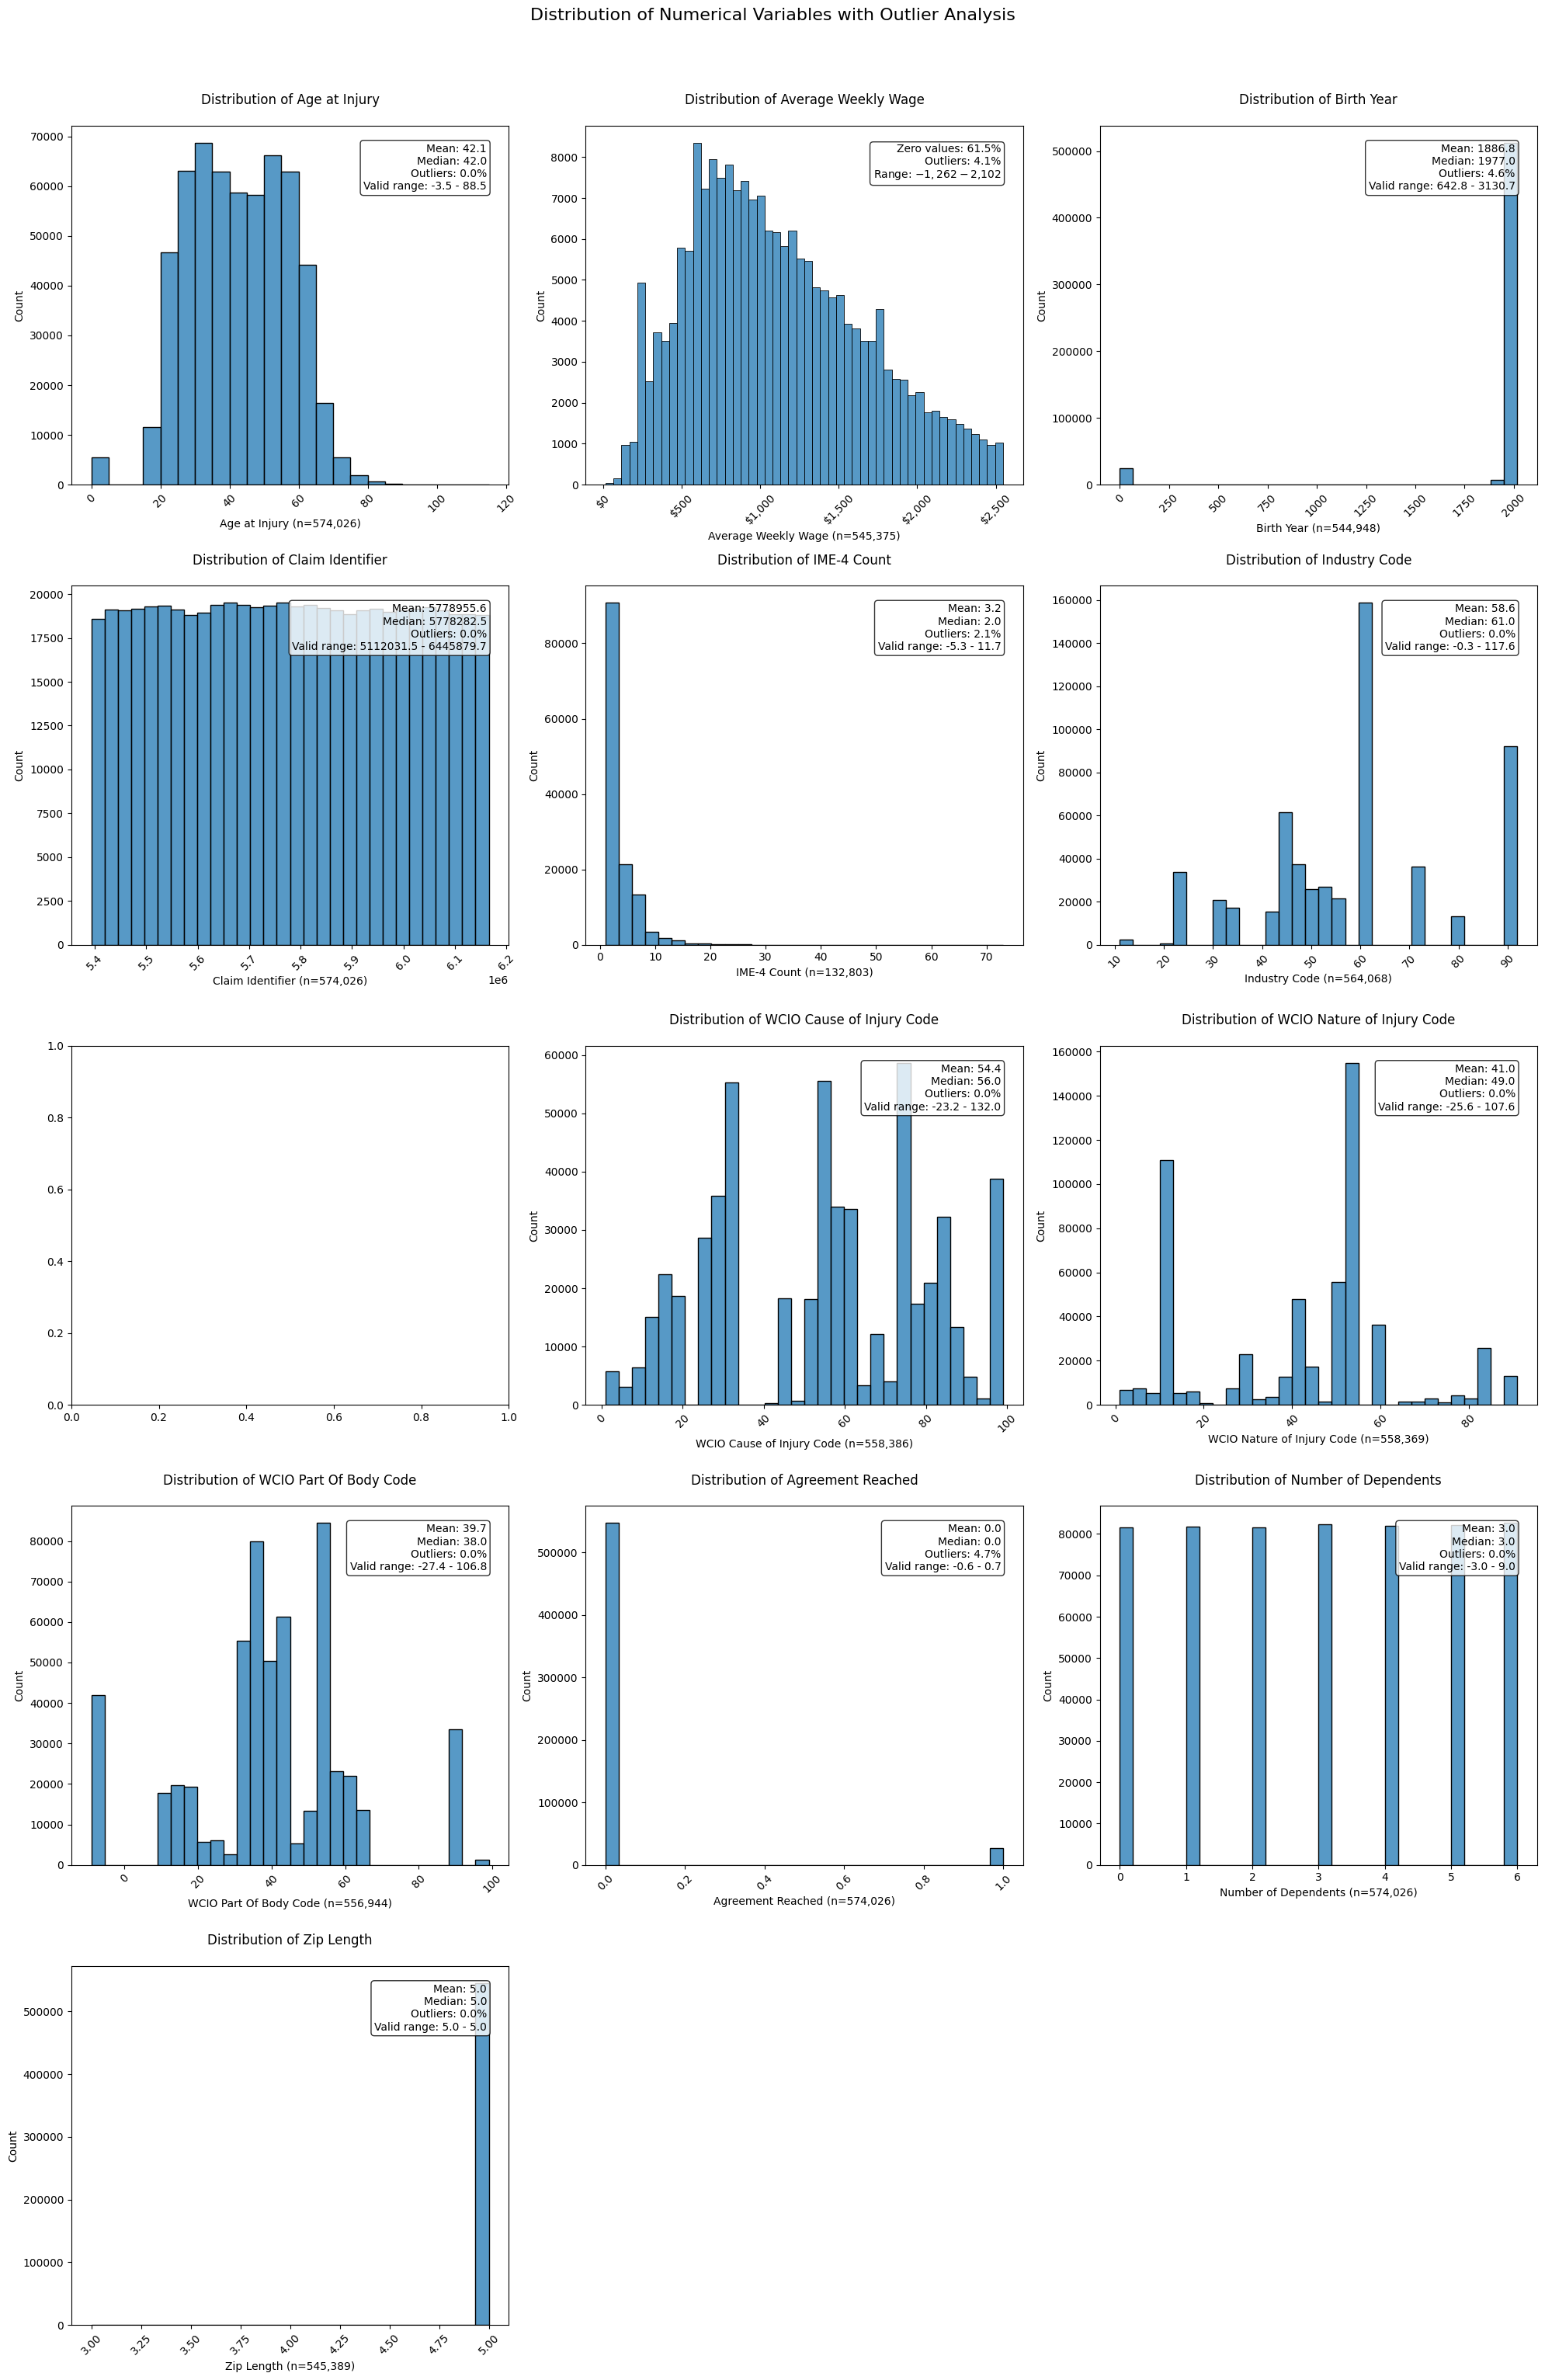


=== Age at Injury ===
count    574026.000000
mean         42.114270
std          14.256432
min           0.000000
25%          31.000000
50%          42.000000
75%          54.000000
max         117.000000
Name: Age at Injury, dtype: float64
Missing values: 0 (0.0%)

Outlier Analysis:
Z-score method (±3σ):
- Outliers: 340 (0.1%)
- Valid range: -0.7 to 84.9

IQR method (1.5×IQR):
- Outliers: 197 (0.0%)
- Valid range: -3.5 to 88.5

Distribution shape:
- Skewness: -0.04 (approximately symmetric)
- Kurtosis: -0.43 (normal-like)
--------------------------------------------------

=== Average Weekly Wage ===
count    5.453750e+05
mean     4.910883e+02
std      6.092918e+03
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      8.410000e+02
max      2.828079e+06
Name: Average Weekly Wage, dtype: float64
Missing values: 28,651 (5.0%)
Zero values: 335,450 (58.4%)

Outlier Analysis:
Z-score method (±3σ):
- Outliers: 34 (0.0%)
- Valid range: -17787.6 to 18769.8

IQR method (1

In [21]:

def detect_outliers(series, method='zscore'):
    """
    Detect outliers using various methods

    Parameters:
    series: pandas Series - numerical data to analyze
    method: str - detection method ('zscore' or 'iqr')

    Returns:
    tuple: (outlier mask, lower bound, upper bound)
    """
    # Convert series to numpy array and handle missing values
    data = pd.to_numeric(series, errors='coerce').dropna().values

    if len(data) == 0:
        return np.array([]), np.nan, np.nan

    if method == 'zscore':
        z_scores = np.abs(stats.zscore(data))
        outliers = z_scores > 3
        lower_bound = np.mean(data) - 3 * np.std(data)
        upper_bound = np.mean(data) + 3 * np.std(data)
    else:  # IQR method
        Q1 = np.percentile(data, 25)
        Q3 = np.percentile(data, 75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        outliers = (data < lower_bound) | (data > upper_bound)

    return outliers, lower_bound, upper_bound

def create_histograms(df):
    """
    Create histograms for all numerical variables with appropriate binning, scaling,
    and outlier detection
    """
    # Identify numeric columns
    numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns.tolist()

    # Calculate number of rows and columns for subplot grid
    n_cols = 3
    n_rows = (len(numeric_cols) + n_cols - 1) // n_cols

    # Create subplots
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 6*n_rows))
    fig.suptitle('Distribution of Numerical Variables with Outlier Analysis', fontsize=16, y=1.02)

    # Flatten axes array for easier iteration
    axes_flat = axes.flatten() if hasattr(axes, 'flatten') else [axes]

    for i, col in enumerate(numeric_cols):
        ax = axes_flat[i]

        # Get non-null values for analysis
        valid_data = pd.to_numeric(df[col], errors='coerce').dropna()

        if len(valid_data) == 0:
            continue

        # Determine outlier detection method based on variable type
        outlier_method = 'iqr' if col in ['Average Weekly Wage', 'Age at Injury'] else 'zscore'

        # Detect outliers
        outliers, lower_bound, upper_bound = detect_outliers(valid_data, method=outlier_method)

        # Custom handling for each variable type
        if 'wage' in col.lower():
            # Plot non-zero wages up to 95th percentile
            non_zero_wages = valid_data[valid_data > 0]
            max_wage = non_zero_wages.quantile(0.95)
            sns.histplot(data=non_zero_wages[non_zero_wages <= max_wage],
                        bins=50, ax=ax)
            ax.set_xlabel(f'${col} (up to 95th percentile)')
            ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x:,.0f}'))

            # Add text about zeros, outliers and anomalies
            zero_pct = (valid_data == 0).mean() * 100
            outlier_pct = np.mean(outliers) * 100
            stats_text = (f'Zero values: {zero_pct:.1f}%\n'
                         f'Outliers: {outlier_pct:.1f}%\n'
                         f'Range: ${lower_bound:,.0f} - ${upper_bound:,.0f}')

        elif 'age' in col.lower():
            sns.histplot(data=valid_data, bins=np.arange(0, 120, 5), ax=ax)
            stats_text = (f'Mean: {valid_data.mean():.1f}\n'
                         f'Median: {valid_data.median():.1f}\n'
                         f'Outliers: {np.mean(outliers):.1%}\n'
                         f'Valid range: {lower_bound:.1f} - {upper_bound:.1f}')

        else:  # For other numerical variables
            sns.histplot(data=valid_data, bins=30, ax=ax)
            stats_text = (f'Mean: {valid_data.mean():.1f}\n'
                         f'Median: {valid_data.median():.1f}\n'
                         f'Outliers: {np.mean(outliers):.1%}\n'
                         f'Valid range: {lower_bound:.1f} - {upper_bound:.1f}')

        # Add statistics
        ax.text(0.95, 0.95, stats_text,
                transform=ax.transAxes,
                verticalalignment='top',
                horizontalalignment='right',
                bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

        # Add title and sample size
        ax.set_title(f'Distribution of {col}', pad=20)
        n_samples = len(valid_data)
        ax.set_xlabel(f'{col} (n={n_samples:,})')

        # Rotate x-axis labels if needed
        if not any(x in col.lower() for x in ['dependent', 'count']):
            ax.tick_params(axis='x', rotation=45)

    # Remove empty subplots if any
    for j in range(i + 1, len(axes_flat)):
        fig.delaxes(axes_flat[j])

    plt.tight_layout()
    return fig

def print_distribution_stats(df):
    """Print detailed distribution statistics including outlier analysis for each numerical variable"""
    # Get numeric columns
    numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns

    for col in numeric_cols:
        print(f"\n=== {col} ===")

        # Convert to numeric and drop invalid values
        valid_data = pd.to_numeric(df[col], errors='coerce')

        # Basic statistics
        stats_df = valid_data.describe()
        print(stats_df)

        # Missing values analysis
        missing_count = valid_data.isna().sum()
        missing_pct = valid_data.isna().mean()
        print(f"Missing values: {missing_count:,} ({missing_pct:.1%})")

        # Zero values analysis (if applicable)
        if 'wage' in col.lower():
            zero_count = (valid_data == 0).sum()
            zero_pct = (valid_data == 0).mean()
            print(f"Zero values: {zero_count:,} ({zero_pct:.1%})")

        # Outlier analysis
        valid_values = valid_data.dropna()
        if len(valid_values) > 0:
            try:
                # Detect outliers using both methods
                zscore_outliers, zscore_lower, zscore_upper = detect_outliers(valid_values, 'zscore')
                iqr_outliers, iqr_lower, iqr_upper = detect_outliers(valid_values, 'iqr')

                print("\nOutlier Analysis:")
                print(f"Z-score method (±3σ):")
                print(f"- Outliers: {np.sum(zscore_outliers):,} ({np.mean(zscore_outliers):.1%})")
                print(f"- Valid range: {zscore_lower:.1f} to {zscore_upper:.1f}")

                print(f"\nIQR method (1.5×IQR):")
                print(f"- Outliers: {np.sum(iqr_outliers):,} ({np.mean(iqr_outliers):.1%})")
                print(f"- Valid range: {iqr_lower:.1f} to {iqr_upper:.1f}")

                # Additional anomaly checks
                skewness = stats.skew(valid_values)
                kurtosis = stats.kurtosis(valid_values)
                print(f"\nDistribution shape:")
                print(f"- Skewness: {skewness:.2f} ({'highly skewed' if abs(skewness) > 1 else 'moderately skewed' if abs(skewness) > 0.5 else 'approximately symmetric'})")
                print(f"- Kurtosis: {kurtosis:.2f} ({'heavy-tailed' if kurtosis > 1 else 'light-tailed' if kurtosis < -1 else 'normal-like'})")

            except Exception as e:
                print(f"Error in outlier analysis: {str(e)}")

        print("-" * 50)

# Usage:
fig = create_histograms(train_df)
plt.show()
print_distribution_stats(train_df)

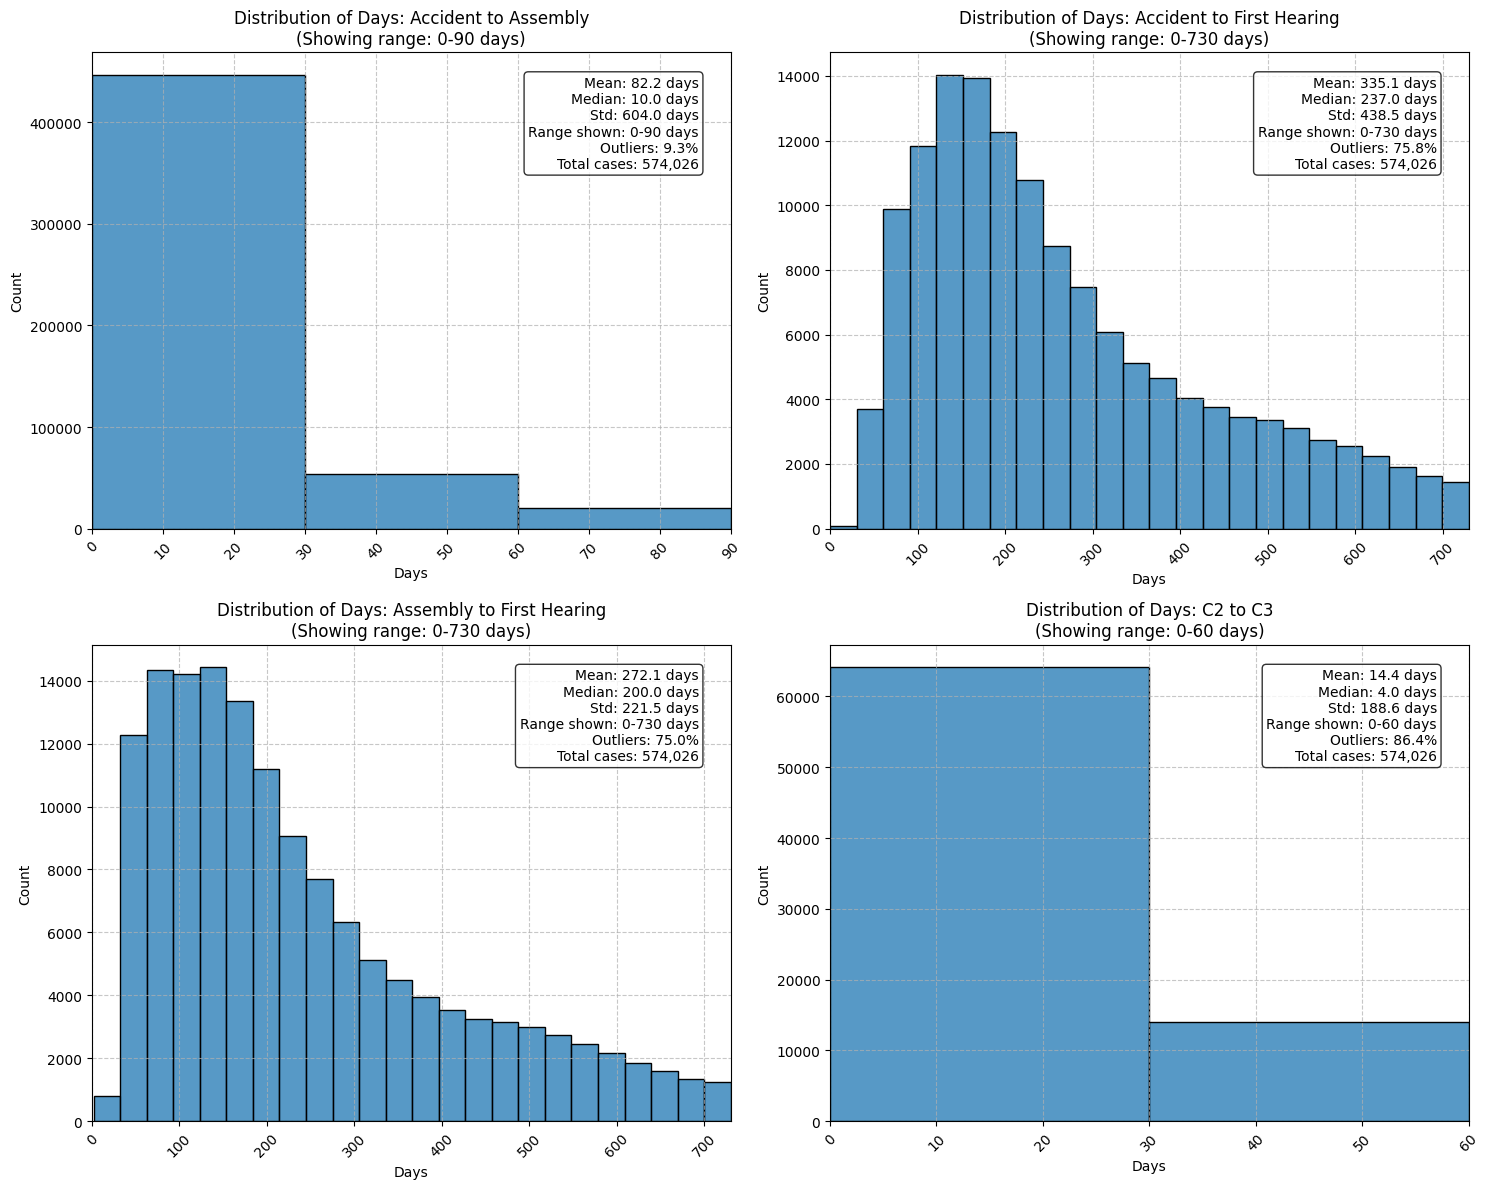


Detailed Interval Analysis:

Accident to Assembly:
--------------------------------------------------
Total cases: 574,026
Valid intervals: 570,337
Missing intervals: 3,689

Key percentiles (days):
25th percentile: 5.0
Median: 10.0
75th percentile: 24.0
90th percentile: 74.0
95th percentile: 165.0
99th percentile: 1007.0

Outlier analysis:
Negative intervals: 1,407 (0.2%)
Intervals > 1 year: 13,430 (2.3%)

Accident to First Hearing:
--------------------------------------------------
Total cases: 574,026
Valid intervals: 149,347
Missing intervals: 424,679

Key percentiles (days):
25th percentile: 147.0
Median: 237.0
75th percentile: 420.0
90th percentile: 646.0
95th percentile: 806.0
99th percentile: 1239.0

Outlier analysis:
Negative intervals: 74 (0.0%)
Intervals > 1 year: 45,196 (7.9%)

Assembly to First Hearing:
--------------------------------------------------
Total cases: 574,026
Valid intervals: 150,798
Missing intervals: 423,228

Key percentiles (days):
25th percentile: 115.0


In [22]:



def analyze_date_intervals(df):
    """
    Analyze intervals between different date variables with adjusted scales
    """
    # Convert date columns to datetime
    date_cols = ['Accident Date', 'Assembly Date', 'C-2 Date', 'C-3 Date', 'First Hearing Date']
    date_df = df[date_cols].apply(pd.to_datetime, errors='coerce')

    # Create figure
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    axes_flat = axes.flatten()

    # Define intervals to analyze
    intervals = [
        ('Accident Date', 'Assembly Date', 'Accident to Assembly', 90),  # Show up to 90 days
        ('Accident Date', 'First Hearing Date', 'Accident to First Hearing', 730),  # Show up to 2 years
        ('Assembly Date', 'First Hearing Date', 'Assembly to First Hearing', 730),  # Show up to 2 years
        ('C-2 Date', 'C-3 Date', 'C2 to C3', 60)  # Show up to 60 days
    ]

    for idx, (start_date, end_date, label, max_days) in enumerate(intervals):
        if all(col in date_df.columns for col in [start_date, end_date]):
            # Calculate interval in days
            interval = (date_df[end_date] - date_df[start_date]).dt.days

            # Filter outliers for visualization but keep them for stats
            interval_filtered = interval[(interval >= 0) & (interval <= max_days)]

            # Plot distribution of intervals
            ax = axes_flat[idx]

            # Create histogram with appropriate bin size
            bin_size = max_days // 30  # Adjust number of bins based on range
            sns.histplot(data=interval_filtered, bins=bin_size, ax=ax)

            # Calculate statistics on full data
            stats = interval.describe()
            outliers_pct = (len(interval) - len(interval_filtered)) / len(interval) * 100

            # Add comprehensive statistics
            stats_text = (
                f"Mean: {stats['mean']:.1f} days\n"
                f"Median: {stats['50%']:.1f} days\n"
                f"Std: {stats['std']:.1f} days\n"
                f"Range shown: 0-{max_days} days\n"
                f"Outliers: {outliers_pct:.1f}%\n"
                f"Total cases: {len(interval):,}"
            )

            ax.text(0.95, 0.95, stats_text,
                   transform=ax.transAxes,
                   verticalalignment='top',
                   horizontalalignment='right',
                   bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

            ax.set_title(f'Distribution of Days: {label}\n(Showing range: 0-{max_days} days)')
            ax.set_xlabel('Days')
            ax.set_ylabel('Count')

            # Set x-axis limits
            ax.set_xlim(0, max_days)

            # Add gridlines for better readability
            ax.grid(True, linestyle='--', alpha=0.7)

            # Rotate x-axis labels for better readability
            ax.tick_params(axis='x', rotation=45)

    plt.tight_layout()
    return fig

def print_interval_details(df):
    """
    Print detailed statistics about the intervals
    """
    date_cols = ['Accident Date', 'Assembly Date', 'C-2 Date', 'C-3 Date', 'First Hearing Date']
    date_df = df[date_cols].apply(pd.to_datetime, errors='coerce')

    intervals = [
        ('Accident Date', 'Assembly Date', 'Accident to Assembly'),
        ('Accident Date', 'First Hearing Date', 'Accident to First Hearing'),
        ('Assembly Date', 'First Hearing Date', 'Assembly to First Hearing'),
        ('C-2 Date', 'C-3 Date', 'C2 to C3')
    ]

    print("\nDetailed Interval Analysis:")
    print("="*80)

    for start_date, end_date, label in intervals:
        if all(col in date_df.columns for col in [start_date, end_date]):
            interval = (date_df[end_date] - date_df[start_date]).dt.days

            print(f"\n{label}:")
            print("-"*50)
            print(f"Total cases: {len(interval):,}")
            print(f"Valid intervals: {interval.notna().sum():,}")
            print(f"Missing intervals: {interval.isna().sum():,}")

            # Calculate percentiles
            percentiles = interval.quantile([0.25, 0.5, 0.75, 0.9, 0.95, 0.99])
            print("\nKey percentiles (days):")
            print(f"25th percentile: {percentiles[0.25]:.1f}")
            print(f"Median: {percentiles[0.5]:.1f}")
            print(f"75th percentile: {percentiles[0.75]:.1f}")
            print(f"90th percentile: {percentiles[0.9]:.1f}")
            print(f"95th percentile: {percentiles[0.95]:.1f}")
            print(f"99th percentile: {percentiles[0.99]:.1f}")

            # Calculate negative and extreme positive intervals
            neg_intervals = (interval < 0).sum()
            extreme_intervals = (interval > 365).sum()

            print("\nOutlier analysis:")
            print(f"Negative intervals: {neg_intervals:,} ({neg_intervals/len(interval)*100:.1f}%)")
            print(f"Intervals > 1 year: {extreme_intervals:,} ({extreme_intervals/len(interval)*100:.1f}%)")

# To use these functions:
fig = analyze_date_intervals(train_df)
plt.show()
print_interval_details(train_df)

# Categorical variable analysis


<ipython-input-23-4f058a0779a8>:69: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  bars = sns.barplot(x=value_counts.values, y=value_counts.index, ax=ax, palette='viridis')
<ipython-input-23-4f058a0779a8>:89: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(labels)
<ipython-input-23-4f058a0779a8>:69: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  bars = sns.barplot(x=value_counts.values, y=value_counts.index, ax=ax, palette='viridis')
<ipython-input-23-4f058a0779a8>:89: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(

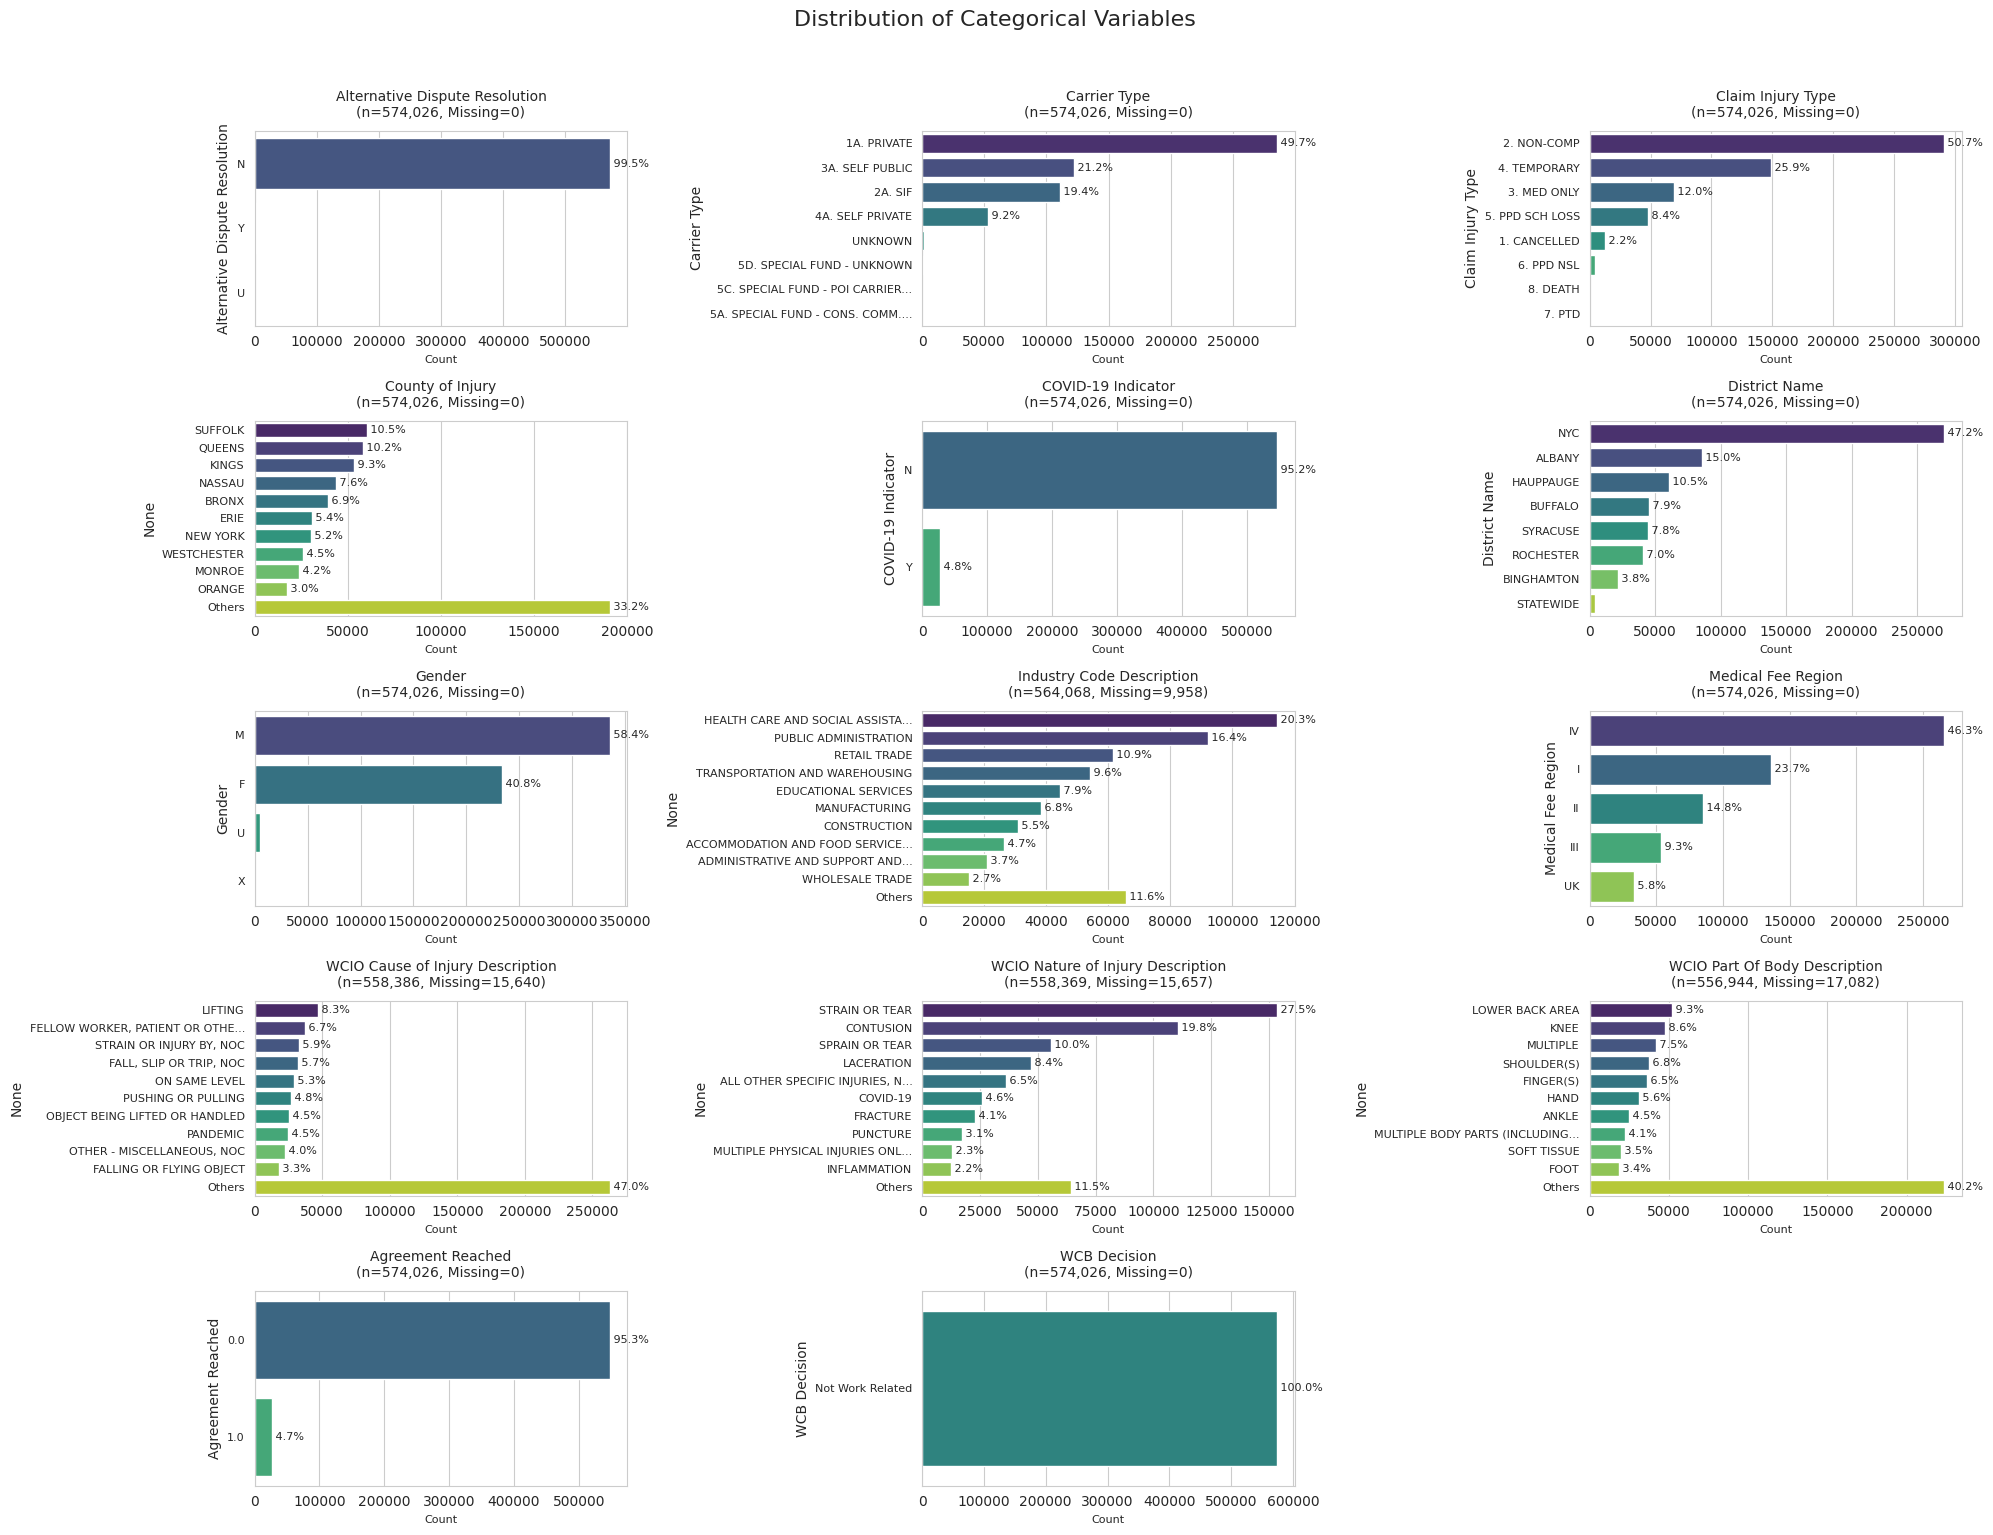

In [23]:

def plot_categorical_distributions(data, figsize=(20, 15), max_categories=10):
    """
    Create bar plots for categorical variables with proper formatting and handling of multiple categories
    """
    # Set the style using seaborn
    sns.set_style("whitegrid")

    # Define categorical columns and verify their presence in the data
    categorical_columns = [
        'Alternative Dispute Resolution',
        'Attorney Representative',
        'Carrier Type',
        'Claim Injury Type',  # Fixed underscore
        'County of Injury',
        'COVID-19 Indicator',
        'District Name',
        'Gender',
        'Industry Code Description',
        'Medical Fee Region',
        'WCIO Cause of Injury Description',
        'WCIO Nature of Injury Description',
        'WCIO Part Of Body Description',
        'Agreement Reached',
        'WCB Decision'
    ]

    # Filter to only include columns that exist in the dataframe
    available_columns = [col for col in categorical_columns if col in data.columns]

    if not available_columns:
        raise ValueError("None of the specified categorical columns found in the dataframe")

    # Calculate number of rows needed (3 columns)
    n_cols = 3
    n_rows = (len(available_columns) + n_cols - 1) // n_cols

    # Create figure with a reasonable size
    fig, axes = plt.subplots(n_rows, n_cols, figsize=figsize)
    fig.suptitle('Distribution of Categorical Variables', fontsize=16, y=1.02)

    # Ensure axes is always a 2D array
    if n_rows == 1:
        axes = np.array([axes])
    if n_cols == 1:
        axes = axes.reshape(-1, 1)

    # Flatten axes for iteration
    axes_flat = axes.flatten()

    for idx, column in enumerate(available_columns):
        try:
            ax = axes_flat[idx]

            # Convert to string if necessary and get value counts
            if data[column].dtype == 'object' or pd.api.types.is_categorical_dtype(data[column]):
                series = data[column]
            else:
                series = data[column].astype(str)

            value_counts = series.value_counts()

            # Handle cases with many categories
            if len(value_counts) > max_categories:
                main_categories = value_counts.head(max_categories)
                others_sum = value_counts[max_categories:].sum()
                value_counts = pd.concat([main_categories, pd.Series({'Others': others_sum})])

            # Create bar plot
            bars = sns.barplot(x=value_counts.values, y=value_counts.index, ax=ax, palette='viridis')

            # Add title and labels
            ax.set_title(f'{column}\n(n={series.notna().sum():,}, Missing={series.isna().sum():,})',
                        fontsize=10, pad=10)
            ax.set_xlabel('Count', fontsize=8)

            # Add percentage labels on bars
            total = value_counts.sum()
            for i, v in enumerate(value_counts.values):
                percentage = (v/total) * 100
                if percentage >= 1:  # Only show percentages >= 1%
                    ax.text(v, i, f' {percentage:.1f}%', va='center', fontsize=8)

            # Adjust layout for better readability
            ax.tick_params(axis='y', labelsize=8)

            # Limit label length if too long
            labels = [str(label)[:30] + '...' if len(str(label)) > 30 else str(label)
                     for label in value_counts.index]
            ax.set_yticklabels(labels)

        except Exception as e:
            print(f"Error plotting {column}: {str(e)}")
            ax.text(0.5, 0.5, f"Error plotting {column}", ha='center', va='center')

    # Remove empty subplots if any
    for j in range(len(available_columns), len(axes_flat)):
        fig.delaxes(axes_flat[j])

    plt.tight_layout()
    return fig

def plot_detailed_categorical(data, column, figsize=(12, 6)):
    """
    Create a detailed bar plot for a specific categorical variable
    """
    sns.set_style("whitegrid")

    try:
        plt.figure(figsize=figsize)

        # Convert to string if necessary
        if data[column].dtype != 'object' and not pd.api.types.is_categorical_dtype(data[column]):
            series = data[column].astype(str)
        else:
            series = data[column]

        value_counts = series.value_counts()
        total = len(data)

        # Create bar plot
        ax = sns.barplot(x=value_counts.index, y=value_counts.values, palette='viridis')

        # Add title and labels
        plt.title(f'Distribution of {column}\n(n={series.notna().sum():,}, Missing={series.isna().sum():,})')
        plt.xlabel(column)
        plt.ylabel('Count')

        # Add percentage labels
        for i, v in enumerate(value_counts.values):
            percentage = (v/total) * 100
            if percentage >= 1:  # Only show percentages >= 1%
                ax.text(i, v, f'{percentage:.1f}%', ha='center', va='bottom')

        # Rotate x-labels if needed
        if len(value_counts.index) > 5 or max(len(str(x)) for x in value_counts.index) > 10:
            plt.xticks(rotation=45, ha='right')

        plt.tight_layout()
        return plt.gcf()

    except Exception as e:
        plt.close()
        print(f"Error plotting {column}: {str(e)}")
        return None

# Example usage:
# Plot all categorical variables
fig = plot_categorical_distributions(train_df)
plt.show()


In [24]:



data= train_df

def analyze_categorical_anomalies(data, categorical_threshold=0.01):
    """
    Performs comprehensive anomaly analysis on categorical variables.

    Parameters:
    -----------
    data : pandas.DataFrame
        Input dataset to analyze
    categorical_threshold : float
        Minimum frequency threshold for rare categories (default: 0.01 or 1%)

    Returns:
    --------
    dict
        Dictionary containing analysis results
    """
    results = {
        'categorical_anomalies': {},
        'summary': {'total_rare_categories': 0}
    }

    def analyze_categorical_column(series):
        """Helper function to analyze categorical columns"""
        # Remove null values for analysis
        series = series.dropna()

        # Calculate value frequencies
        value_counts = series.value_counts(normalize=True)
        rare_categories = value_counts[value_counts < categorical_threshold]

        # Calculate absolute counts for reporting
        absolute_counts = series.value_counts()

        return {
            'rare_categories': rare_categories.index.tolist(),
            'rare_frequencies': rare_categories.values.tolist(),
            'rare_absolute_counts': [absolute_counts[cat] for cat in rare_categories.index],
            'total_rare_categories': len(rare_categories),
            'most_common': value_counts.index[0],
            'most_common_freq': value_counts.iloc[0],
            'unique_categories': len(value_counts),
            'missing_values': series.isnull().sum(),
            'total_records': len(series)
        }

    # Analyze categorical columns
    categorical_cols = data.select_dtypes(include=['object', 'category']).columns

    for col in categorical_cols:
        if data[col].notna().any():  # Only analyze if column has non-null values
            results['categorical_anomalies'][col] = analyze_categorical_column(data[col])
            results['summary']['total_rare_categories'] += results['categorical_anomalies'][col]['total_rare_categories']

    return results

def plot_category_distributions(data, results, column, figsize=(12, 6)):
    """
    Creates visualization for category distribution with rare categories highlighted.

    Parameters:
    -----------
    data : pandas.DataFrame
        Input dataset
    results : dict
        Results from analyze_categorical_anomalies function
    column : str
        Column name to visualize
    figsize : tuple
        Figure size for plot
    """
    if column not in results['categorical_anomalies']:
        print(f"No analysis results found for column: {column}")
        return None

    plt.figure(figsize=figsize)

    # Get column data
    series = data[column].dropna()
    value_counts = series.value_counts()

    # Create color map (rare categories in red, others in blue)
    rare_cats = set(results['categorical_anomalies'][column]['rare_categories'])
    colors = ['red' if cat in rare_cats else 'blue' for cat in value_counts.index]

    # Create bar plot
    ax = sns.barplot(x=value_counts.index, y=value_counts.values, palette=colors)

    # Add title and labels
    stats = results['categorical_anomalies'][column]
    title = (f'Distribution of {column}\n'
             f'Total Categories: {stats["unique_categories"]}, '
             f'Rare Categories: {stats["total_rare_categories"]}\n'
             f'Missing Values: {stats["missing_values"]} '
             f'({stats["missing_values"]/stats["total_records"]*100:.1f}%)')

    plt.title(title)
    plt.xlabel(column)
    plt.ylabel('Count')

    # Add percentage labels
    total = len(series)
    for i, v in enumerate(value_counts.values):
        percentage = (v/total) * 100
        if percentage >= 1:  # Only show percentages >= 1%
            ax.text(i, v, f'{percentage:.1f}%', ha='center', va='bottom')

    # Rotate x-labels if needed
    if len(value_counts.index) > 5 or max(len(str(x)) for x in value_counts.index) > 10:
        plt.xticks(rotation=45, ha='right')

    plt.tight_layout()
    return plt.gcf()

def generate_categorical_analysis_report(data, categorical_threshold=0.01):
    """
    Generates a comprehensive categorical anomaly analysis report.

    Parameters:
    -----------
    data : pandas.DataFrame
        Input dataset to analyze
    categorical_threshold : float
        Minimum frequency threshold for rare categories

    Returns:
    --------
    tuple
        (analysis_results, summary_text)
    """
    # Perform analysis
    results = analyze_categorical_anomalies(data, categorical_threshold)

    # Generate summary report
    summary = []
    summary.append("=== Categorical Anomaly Analysis Report ===\n")

    # Overall summary
    summary.append(f"Total number of rare categories detected: {results['summary']['total_rare_categories']}")
    summary.append(f"Analysis threshold: Categories occurring in less than {categorical_threshold*100}% of records\n")

    # Detailed categorical analysis
    summary.append("=== Categorical Variables Analysis ===")
    for col, stats in results['categorical_anomalies'].items():
        summary.append(f"\n{col}:")
        summary.append(f"- Total unique categories: {stats['unique_categories']}")
        summary.append(f"- Missing values: {stats['missing_values']} ({stats['missing_values']/stats['total_records']*100:.1f}%)")
        summary.append(f"- Most common value: {stats['most_common']} ({stats['most_common_freq']*100:.1f}%)")
        summary.append(f"- Number of rare categories: {stats['total_rare_categories']}")

        if stats['total_rare_categories'] > 0:
            summary.append("- Rare categories (top 5):")
            for cat, freq, count in zip(
                stats['rare_categories'][:5],
                stats['rare_frequencies'][:5],
                stats['rare_absolute_counts'][:5]
            ):
                summary.append(f"  * {cat}: {count} occurrences ({freq*100:.2f}%)")

    return results, "\n".join(summary)

# Example usage:

# Analyze the data
results, report = generate_categorical_analysis_report(data)
print(report)

# Create visualization for a specific column
fig = plot_category_distributions(data, results, 'your_column_name')
plt.show()


=== Categorical Anomaly Analysis Report ===

Total number of rare categories detected: 22145
Analysis threshold: Categories occurring in less than 1.0% of records

=== Categorical Variables Analysis ===

Accident Date:
- Total unique categories: 5539
- Missing values: 0 (0.0%)
- Most common value: 2020-03-01 (0.2%)
- Number of rare categories: 5539
- Rare categories (top 5):
  * 2020-03-01: 1245 occurrences (0.22%)
  * 2020-12-18: 1001 occurrences (0.18%)
  * 2022-02-07: 977 occurrences (0.17%)
  * 2022-01-05: 883 occurrences (0.15%)
  * 2021-02-18: 851 occurrences (0.15%)

Alternative Dispute Resolution:
- Total unique categories: 3
- Missing values: 0 (0.0%)
- Most common value: N (99.5%)
- Number of rare categories: 2
- Rare categories (top 5):
  * Y: 2609 occurrences (0.45%)
  * U: 5 occurrences (0.00%)

Assembly Date:
- Total unique categories: 897
- Missing values: 0 (0.0%)
- Most common value: 2020-03-06 (0.2%)
- Number of rare categories: 897
- Rare categories (top 5):
  * 2020

# **Dealing with outliers and anomalies**

Numerical outliers & Anomalies


Average Weekly Wage > KNN- imputer

Highly problematic distribution with severe anomalies:
56.5% zero values, suggesting massive data quality issues or misreporting
Extreme right skew (378.98) and kurtosis (160,019.57)
Maximum value of $2.8M appears implausible for weekly wage
IQR method identifies 4.1% outliers, more reliable than z-score due to non-normal distribution
Recommendation: Implement wage validation rules and investigate zero-value cases


Birth Year

Severe data quality issues evident:
Range from 0 to 2018 is impossible for worker birth years
4.6% outliers identified by both methods
Valid range should be approximately 1929-2025 (IQR method)
Many impossible values (year 0) need cleaning
Recommendation: Implement strict validation rules for birth year entries


Age at Injury

Generally well-behaved but with some concerns:
Range 0-117 years includes implausible values
Only 0.1% outliers (z-score method)
Nearly symmetric distribution (skewness -0.04)
Recommendation: Flag cases with age > 80 for verification

IME-4 Count

High missing rate (77.6%) is concerning
Right-skewed distribution (2.59)
Maximum of 73 counts seems unusually high
5.4% outliers by IQR method
Recommendation: Investigate cases with counts > 8


WCIO Part of Body Code

Unusual negative values (minimum -9)
High outlier rate (13.8%) by IQR method
Needs standardization to valid codes
Recommendation: Clean negative values and validate against standard codes

# **Multivariate relationship analysis**

Cramers V w Chi-Square
Pairplots
Scatterplot with Y


In [25]:
train_df.dtypes

,0
Accident Date,object
Age at Injury,float64
Alternative Dispute Resolution,object
Assembly Date,object
Attorney/Representative,object
Average Weekly Wage,float64
Birth Year,float64
C-2 Date,object
C-3 Date,object
Carrier Name,object


<ipython-input-26-2be627b425cc>:33: UserWarning: Dropping Carrier Name: 2046 unique values exceeds maximum of 100
  warnings.warn(f"Dropping {col}: {n_unique} unique values exceeds maximum of {max_unique_values}")
<ipython-input-26-2be627b425cc>:63: RuntimeWarning: invalid value encountered in scalar divide
  v = np.sqrt(phi2corr/min((kcorr-1),(rcorr-1)))
<ipython-input-26-2be627b425cc>:63: RuntimeWarning: invalid value encountered in scalar divide
  v = np.sqrt(phi2corr/min((kcorr-1),(rcorr-1)))
<ipython-input-26-2be627b425cc>:63: RuntimeWarning: invalid value encountered in scalar divide
  v = np.sqrt(phi2corr/min((kcorr-1),(rcorr-1)))
<ipython-input-26-2be627b425cc>:63: RuntimeWarning: invalid value encountered in scalar divide
  v = np.sqrt(phi2corr/min((kcorr-1),(rcorr-1)))
<ipython-input-26-2be627b425cc>:63: RuntimeWarning: invalid value encountered in scalar divide
  v = np.sqrt(phi2corr/min((kcorr-1),(rcorr-1)))
<ipython-input-26-2be627b425cc>:63: RuntimeWarning: invalid value 


Strongest Categorical Correlations:
--------------------------------------------------
COVID-19 Indicator -- WCIO Nature of Injury Description: 0.980
COVID-19 Indicator -- WCIO Cause of Injury Description: 0.970
County of Injury -- District Name: 0.909
COVID-19 Indicator -- WCIO Part Of Body Description: 0.833
County of Injury -- Medical Fee Region: 0.722
Attorney/Representative -- Claim Injury Type: 0.611
District Name -- Medical Fee Region: 0.492
Carrier Type -- Industry Code Description: 0.322
WCIO Cause of Injury Description -- WCIO Nature of Injury Description: 0.301
Attorney/Representative -- WCIO Cause of Injury Description: 0.282
Attorney/Representative -- WCIO Part Of Body Description: 0.275
Attorney/Representative -- WCIO Nature of Injury Description: 0.257
WCIO Nature of Injury Description -- WCIO Part Of Body Description: 0.256
Gender -- Industry Code Description: 0.253
Attorney/Representative -- Industry Code Description: 0.243
Attorney/Representative -- County of Injury:

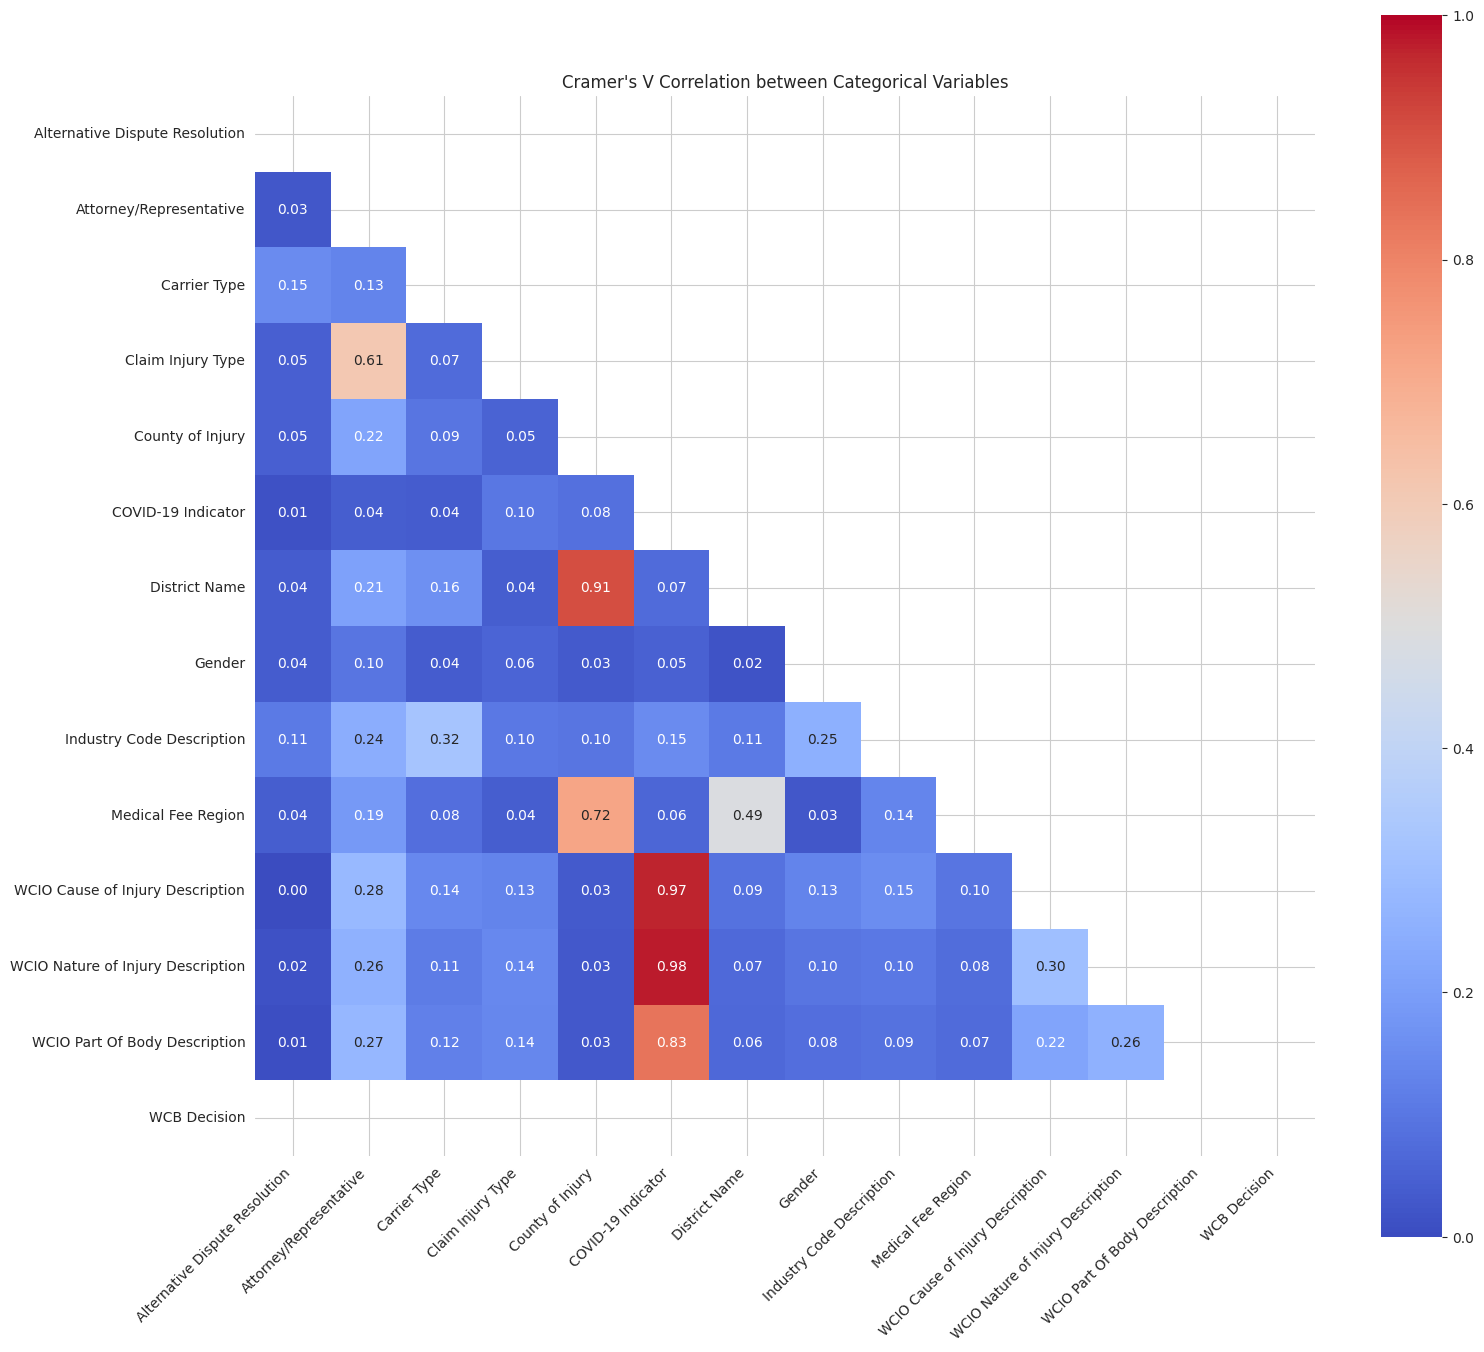

In [26]:


def compute_cramers_v_matrix(df: pd.DataFrame,
                           categorical_cols: Optional[List[str]] = None,
                           threshold: float = 0.0,
                           max_unique_values: int = 100) -> pd.DataFrame:
    """
    Compute Cramer's V correlation matrix for categorical variables.

    Parameters:
    -----------
    df : pandas DataFrame
        Input DataFrame containing the categorical variables
    categorical_cols : list of str, optional
        List of categorical column names. If None, will use all object columns
    threshold : float, optional
        Minimum correlation value to display (0.0 to 1.0)
    max_unique_values : int, optional
        Maximum number of unique values allowed for a categorical variable

    Returns:
    --------
    pd.DataFrame
        Cramer's V correlation matrix
    """
    # If no categorical columns specified, use all object columns
    if categorical_cols is None:
        categorical_cols = df.select_dtypes(include=['object']).columns.tolist()

    # Filter out columns with too many unique values
    valid_cols = []
    for col in categorical_cols:
        n_unique = df[col].nunique()
        if n_unique > max_unique_values:
            warnings.warn(f"Dropping {col}: {n_unique} unique values exceeds maximum of {max_unique_values}")
        else:
            valid_cols.append(col)

    # Initialize the correlation matrix
    n_cols = len(valid_cols)
    cramer_matrix = np.zeros((n_cols, n_cols))

    # Compute Cramer's V for each pair of variables
    for i in range(n_cols):
        for j in range(i, n_cols):  # Only compute upper triangle
            if i == j:
                cramer_matrix[i][j] = 1.0
            else:
                try:
                    # Create contingency table
                    confusion_matrix = pd.crosstab(df[valid_cols[i]], df[valid_cols[j]])

                    # Compute Chi-square and Cramer's V
                    chi2 = chi2_contingency(confusion_matrix)[0]
                    n = confusion_matrix.sum().sum()
                    phi2 = chi2/n
                    r, k = confusion_matrix.shape

                    # Apply correction
                    phi2corr = max(0, phi2-((k-1)*(r-1))/(n-1))
                    rcorr = r-((r-1)**2)/(n-1)
                    kcorr = k-((k-1)**2)/(n-1)

                    # Calculate Cramer's V
                    v = np.sqrt(phi2corr/min((kcorr-1),(rcorr-1)))

                    # Store value in both triangles of the matrix
                    cramer_matrix[i][j] = v
                    cramer_matrix[j][i] = v

                except Exception as e:
                    warnings.warn(f"Error computing Cramer's V for {valid_cols[i]} and {valid_cols[j]}: {str(e)}")
                    cramer_matrix[i][j] = np.nan
                    cramer_matrix[j][i] = np.nan

    # Convert to DataFrame
    cramer_df = pd.DataFrame(cramer_matrix,
                            index=valid_cols,
                            columns=valid_cols)

    return cramer_df

def plot_cramers_v_heatmap(cramer_df: pd.DataFrame,
                          threshold: float = 0.0,
                          figsize: tuple = (16, 14),
                          cmap: str = 'coolwarm',
                          annot_fmt: str = '.2f') -> None:
    """
    Plot heatmap of Cramer's V correlation matrix.

    Parameters:
    -----------
    cramer_df : pandas DataFrame
        Cramer's V correlation matrix
    threshold : float, optional
        Minimum correlation value to display
    figsize : tuple, optional
        Figure size (width, height)
    cmap : str, optional
        Color map for heatmap
    annot_fmt : str, optional
        Format string for annotation values
    """
    # Apply threshold mask
    mask = np.zeros_like(cramer_df)
    mask[np.triu_indices_from(mask)] = True

    # Create plot
    plt.figure(figsize=figsize)
    sns.heatmap(cramer_df,
                annot=True,
                cmap=cmap,
                fmt=annot_fmt,
                mask=mask,
                square=True,
                vmin=0,
                vmax=1,
                center=0.5)

    plt.title("Cramer's V Correlation between Categorical Variables")
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()

def analyze_categorical_correlations(df: pd.DataFrame,
                                  categorical_cols: Optional[List[str]] = None,
                                  threshold: float = 0.0,
                                  max_unique_values: int = 100,
                                  print_summary: bool = True) -> pd.DataFrame:
    """
    Perform complete Cramer's V analysis including matrix computation and visualization.

    Parameters:
    -----------
    df : pandas DataFrame
        Input DataFrame containing the categorical variables
    categorical_cols : list of str, optional
        List of categorical column names. If None, will use all object columns
    threshold : float, optional
        Minimum correlation value to display
    max_unique_values : int, optional
        Maximum number of unique values allowed for a categorical variable
    print_summary : bool, optional
        Whether to print summary of strongest correlations

    Returns:
    --------
    pd.DataFrame
        Cramer's V correlation matrix
    """
    # Compute Cramer's V matrix
    cramer_df = compute_cramers_v_matrix(df, categorical_cols, threshold, max_unique_values)

    # Plot heatmap
    plot_cramers_v_heatmap(cramer_df, threshold)

    # Print summary if requested
    if print_summary:
        print("\nStrongest Categorical Correlations:")
        print("-" * 50)

        # Get upper triangle of correlation matrix
        upper_tri = cramer_df.where(np.triu(np.ones(cramer_df.shape), k=1).astype(bool))

        # Stack and sort correlations
        stacked = upper_tri.stack().sort_values(ascending=False)

        # Print top correlations
        for (var1, var2), corr in stacked[stacked > threshold].items():
            print(f"{var1} -- {var2}: {corr:.3f}")

    return cramer_df

# Get categorical columns (excluding certain columns if desired)
categorical_cols = [
    'Alternative Dispute Resolution',
    'Attorney/Representative',
    'Carrier Name',
    'Carrier Type',
    'Claim Injury Type',
    'County of Injury',
    'COVID-19 Indicator',
    'District Name',
    'Gender',
    'Industry Code Description',
    'Medical Fee Region',
    'WCIO Cause of Injury Description',
    'WCIO Nature of Injury Description',
    'WCIO Part Of Body Description',
    'WCB Decision'
]

# Run the analysis
results = analyze_categorical_correlations(
    df=train_df,
    categorical_cols=categorical_cols,
    threshold=0.1,  # Show correlations > 0.1
    max_unique_values=100,  # Skip columns with more than 100 unique values
    print_summary=True
)

Key Insights for Business from CHI square cramers V

Data Redundancy:

Geographic variables (County, District, Fee Region) show high correlation
Consider consolidating these for more efficient data modeling


COVID-19 Impact:

Strong correlations suggest distinct patterns in COVID-related claims
Might warrant separate analysis or modeling strategies for COVID vs non-COVID claims


Legal Representation Patterns:

Moderate correlation with injury type suggests predictable patterns
Could be used for early case assessment and resource allocation


Independent Variables:

Gender and Alternative Dispute Resolution show independence
Good candidates for independent variables in predictive models

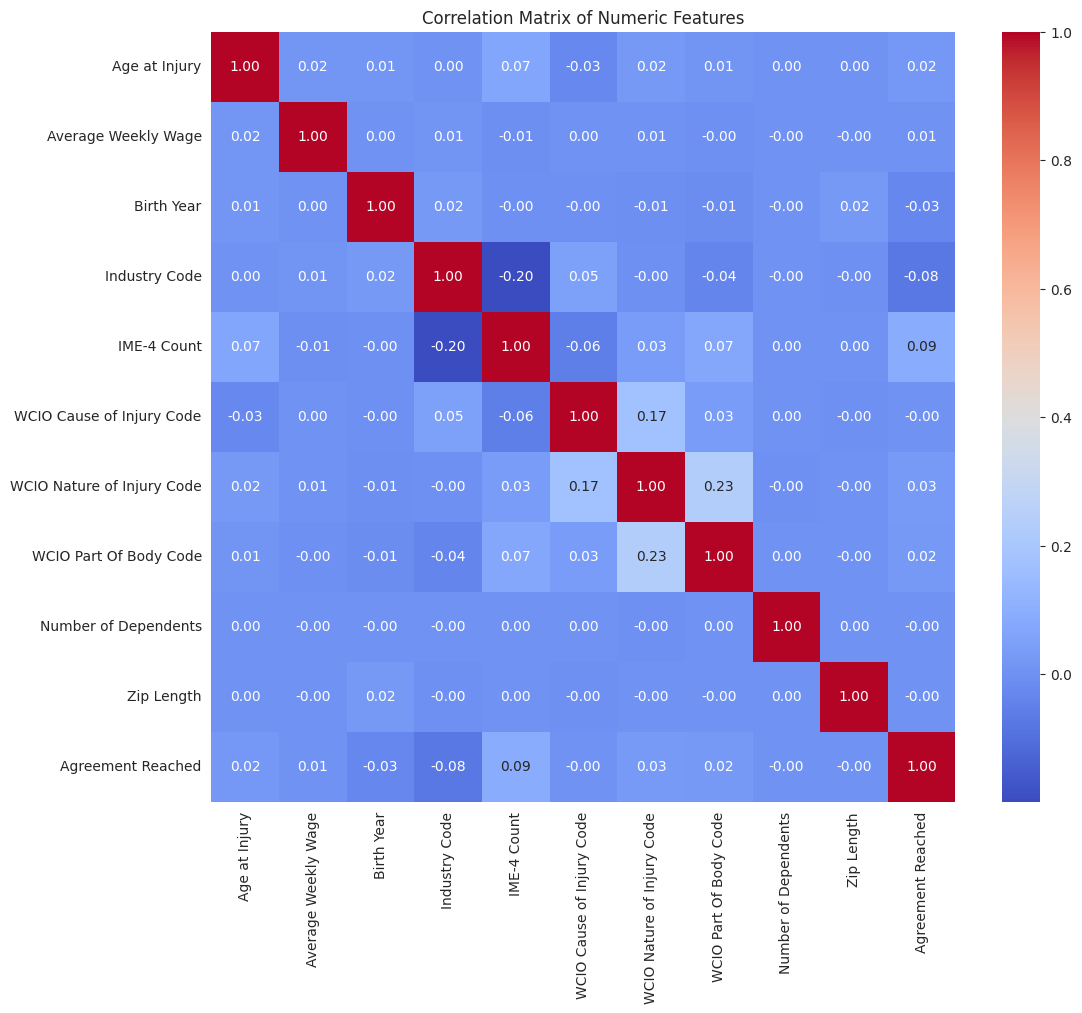

In [27]:


numeric_cols = [
    'Age at Injury',
    'Average Weekly Wage',
    'Birth Year',
    'Industry Code',
    'IME-4 Count',
    'WCIO Cause of Injury Code',
    'WCIO Nature of Injury Code',
    'WCIO Part Of Body Code',
    'Number of Dependents',
    'Zip Length',
    'Agreement Reached'
]

# Calculate the correlation matrix
correlation_matrix = train_df[numeric_cols].corr()

# Display the correlation matrix using a heatmap for better visualization
plt.figure(figsize=(12, 10))  # Adjust figure size as needed
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix of Numeric Features")
plt.show()

<ipython-input-28-2d161eb127c6>:32: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_sample = df_clean.groupby('Claim Injury Type').apply(
<ipython-input-28-2d161eb127c6>:57: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  sns.violinplot(
<ipython-input-28-2d161eb127c6>:57: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  sns.violinplot(
<ipython-input-28-2d161eb127c6>:57: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  sns.violi


Feature Importance for Predicting Claim Injury Type:
                   Feature  Importance
       Average Weekly Wage    0.477627
               IME-4 Count    0.148201
    WCIO Part Of Body Code    0.079847
WCIO Nature of Injury Code    0.078493
         Agreement Reached    0.066679
 WCIO Cause of Injury Code    0.066150
             Industry Code    0.044136
             Age at Injury    0.015429
                Birth Year    0.011107
                Zip Length    0.004250
      Number of Dependents    0.000000

Summary Statistics by Claim Type:

Age at Injury:
                    mean    std  count
Claim Injury Type                     
1. CANCELLED       38.54  19.92   1086
2. NON-COMP        40.76  14.53  25354
3. MED ONLY        42.17  14.04   6001
4. TEMPORARY       43.49  13.47  12935
5. PPD SCH LOSS    45.71  12.34   4205
6. PPD NSL         47.73  12.11    366
7. PTD             47.25  13.46      8
8. DEATH           53.88  13.07     40

Average Weekly Wage:
               

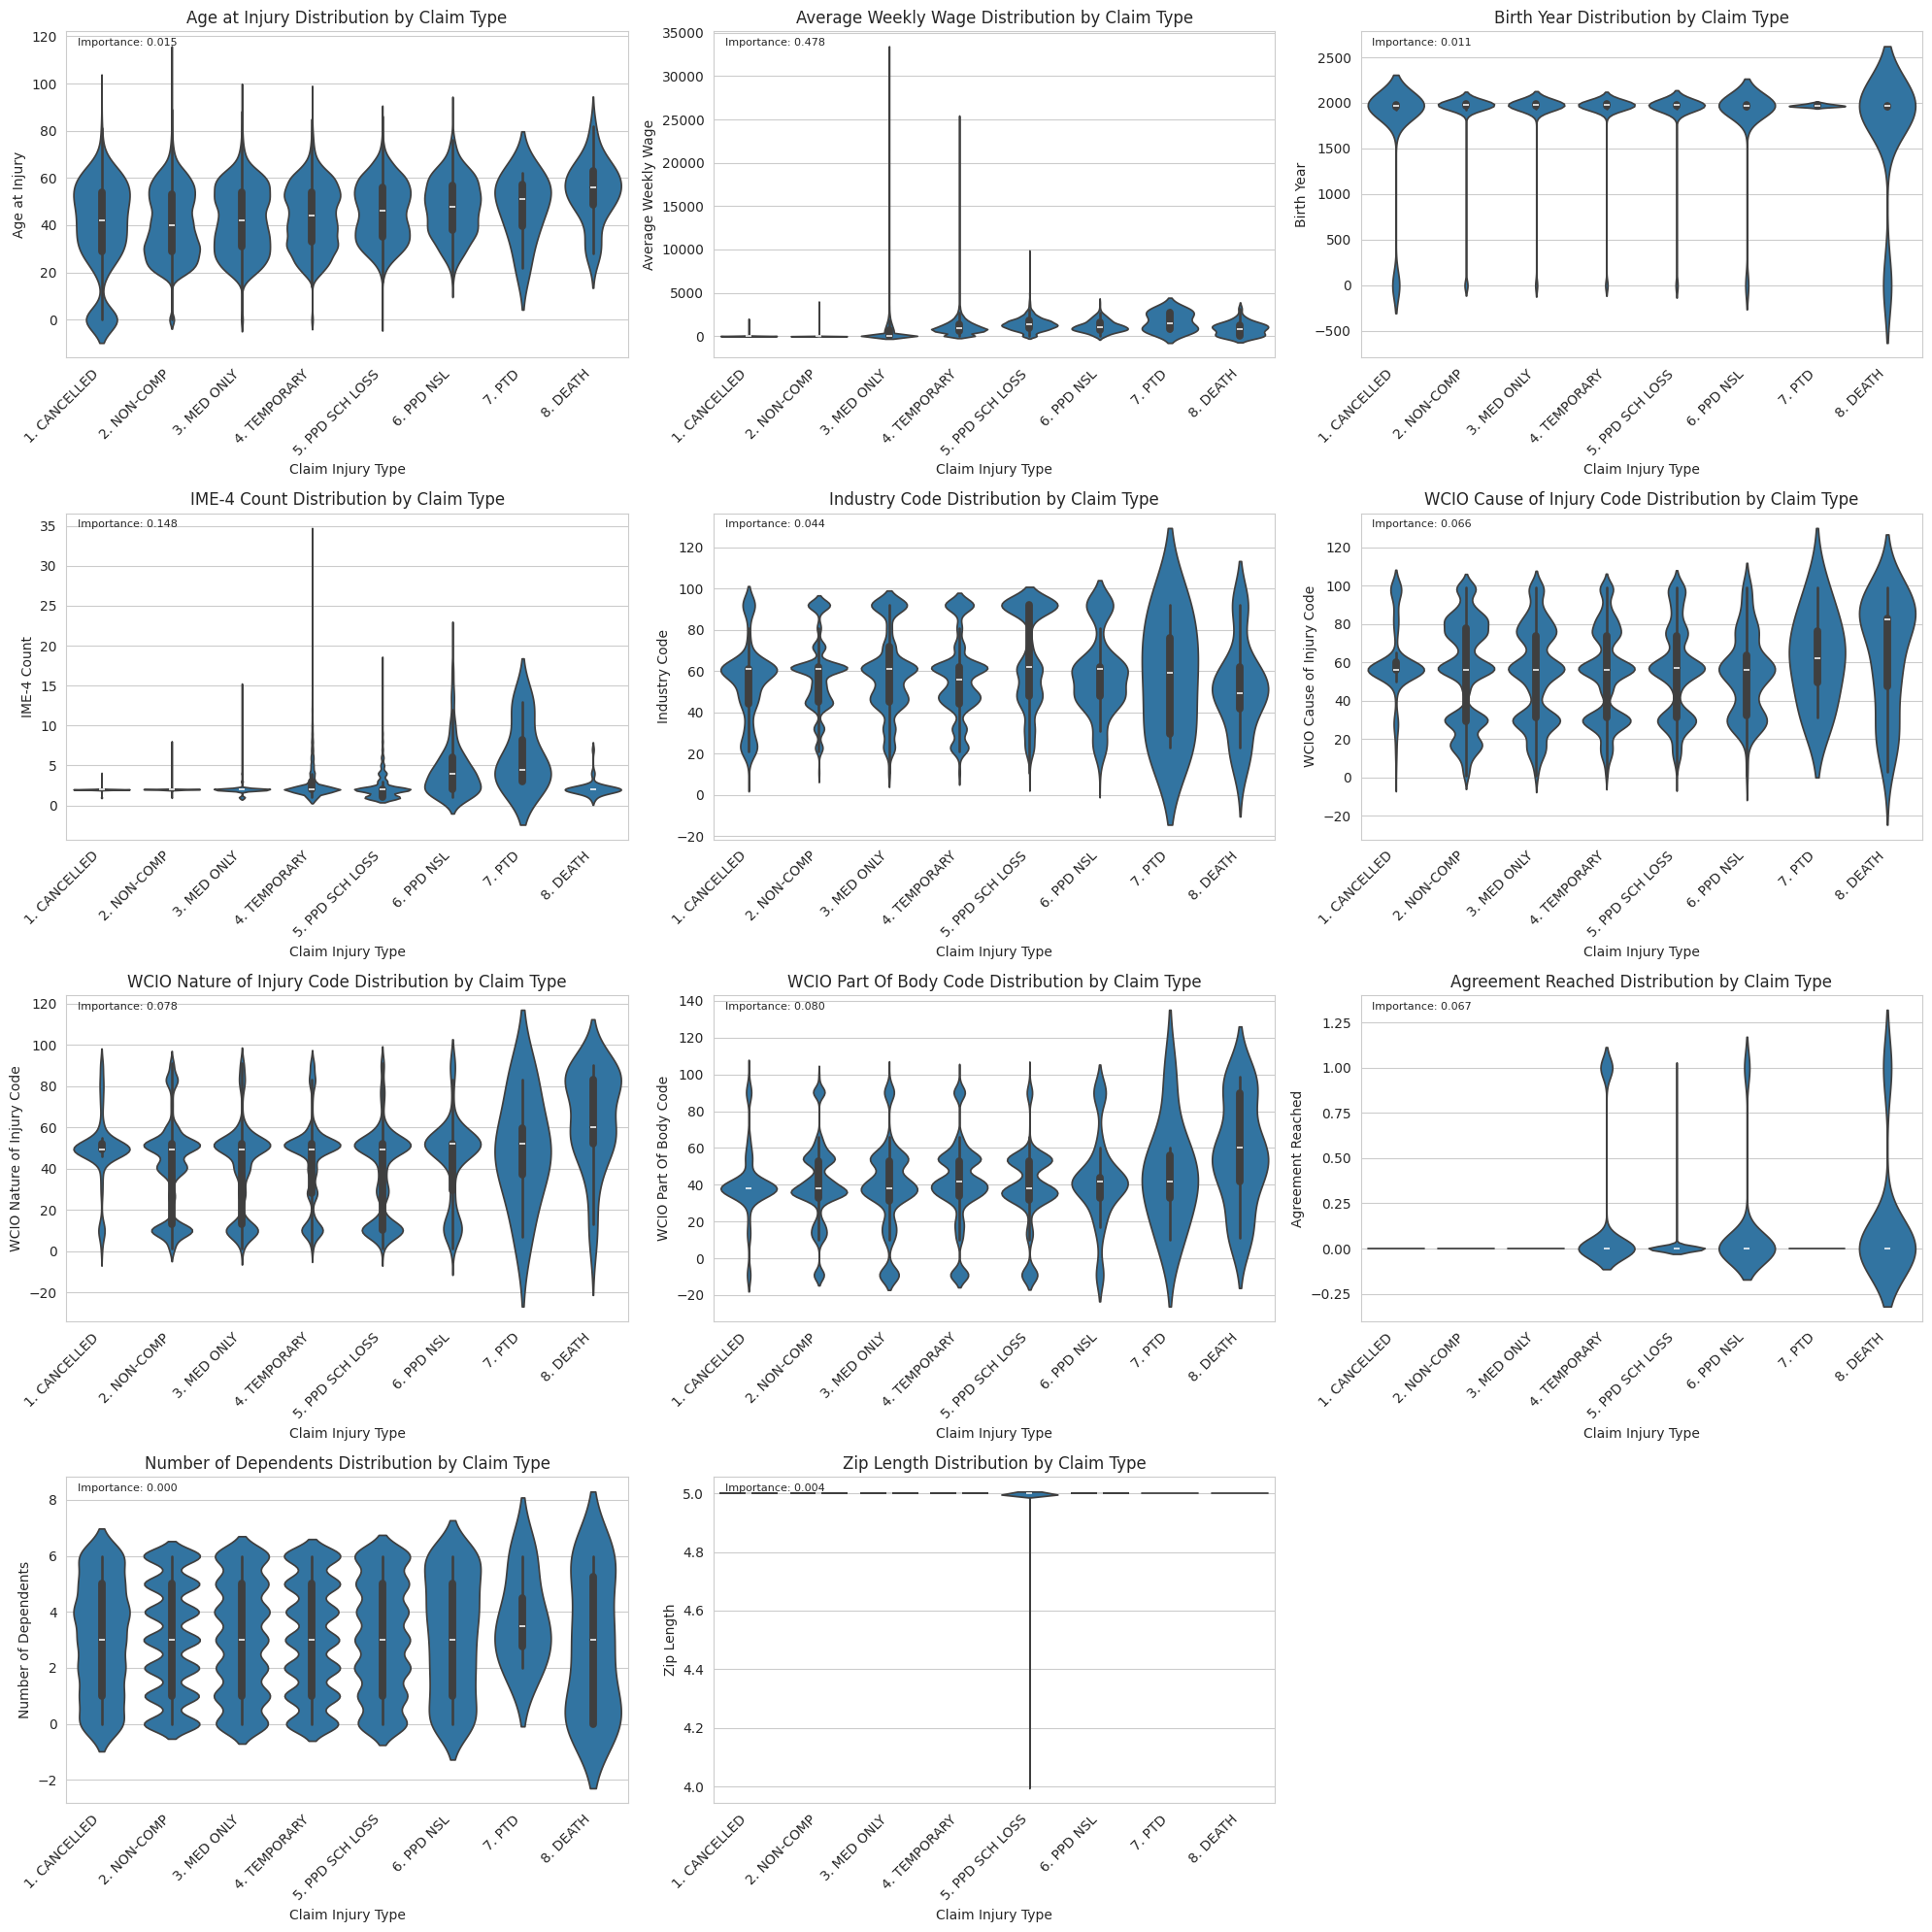

In [28]:
# pairplotting with Y


def create_target_focused_analysis(df, sample_size=50000):
    """
    Create visualizations focusing on relationships with Claim Injury Type
    """
    # Create a copy and handle missing values
    df_clean = df.copy()

    # Select all relevant numeric columns
    numeric_cols = [
        'Age at Injury',
        'Average Weekly Wage',
        'Birth Year',
        'IME-4 Count',
        'Industry Code',
        'WCIO Cause of Injury Code',
        'WCIO Nature of Injury Code',
        'WCIO Part Of Body Code',
        'Agreement Reached',
        'Number of Dependents',
        'Zip Length'
    ]

    # Handle missing values
    for col in numeric_cols:
        df_clean[col] = df_clean[col].fillna(df_clean[col].median())

    # Sample the data with stratification
    if len(df_clean) > sample_size:
        df_sample = df_clean.groupby('Claim Injury Type').apply(
            lambda x: x.sample(n=min(len(x), int(sample_size * len(x)/len(df_clean))),
                             random_state=42)
        ).reset_index(drop=True)
    else:
        df_sample = df_clean.copy()

    # Calculate feature importance
    X = df_sample[numeric_cols]
    y = df_sample['Claim Injury Type']
    mi_scores = mutual_info_classif(X, y)
    importance_df = pd.DataFrame({
        'Feature': numeric_cols,
        'Importance': mi_scores
    }).sort_values('Importance', ascending=False)

    # Create subplots for each numeric feature vs Claim Injury Type
    n_cols = 3
    n_rows = (len(numeric_cols) + n_cols - 1) // n_cols
    fig = plt.figure(figsize=(20, 5*n_rows))

    for idx, feature in enumerate(numeric_cols):
        plt.subplot(n_rows, n_cols, idx + 1)

        # Create violin plot for each feature
        sns.violinplot(
            data=df_sample,
            x='Claim Injury Type',
            y=feature,
            scale='width'
        )
        plt.xticks(rotation=45, ha='right')
        plt.title(f'{feature} Distribution by Claim Type')

        # Add feature importance score
        importance = importance_df[importance_df['Feature'] == feature]['Importance'].values[0]
        plt.text(0.02, 0.98, f'Importance: {importance:.3f}',
                transform=plt.gca().transAxes,
                verticalalignment='top',
                fontsize=8)

    plt.tight_layout()

    # Print feature importance summary
    print("\nFeature Importance for Predicting Claim Injury Type:")
    print(importance_df.to_string(index=False))

    # Print summary statistics for each feature by claim type
    print("\nSummary Statistics by Claim Type:")
    for feature in numeric_cols:
        print(f"\n{feature}:")
        print(df_sample.groupby('Claim Injury Type')[feature].agg(['mean', 'std', 'count']).round(2))

    return fig, importance_df

# Create the visualizations
fig, importance_df = create_target_focused_analysis(train_df)
plt.show()